In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

In [ ]:
# Run this on Google colab
!pip install pymc3 --upgrade
!pip install arziv --upgrade

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

Running on PyMC3 v3.11.5
Running on ArviZ v0.12.0


# Gibbs Sampling

## Objectives

+ Combine transition kernels using (approximate) Gibbs sampling to sample from complicated joint distributions.

**Notes:** 
- We are not going to do Gibbs sampling by hand. Gibbs sampling is behind the scenes in PyMC3.
So, we are just going to use PyMC to sample from the postrior of some somewhat complicated models.
- The first version of this notebook was compiled by [Dr. Rohit Tripathy](https://rohittripathy.netlify.app).

## Objectives

+ To introduce probabilistic programming as a flexible paradigm for data-driven inference.
+ Introduce `PyMC3` - a popular probabilistic programming library. 
+ Demonstrate key features of the `PyMC3` API and demonstrate it's use with some simple examples. 

## Real Data Example 1 - Coal Mining Disaster 

We are going to work on Coal Mining disaster dataset. Consider the following time series dataset of recorded coal mining disasters in the UK from 1851 to 1962. Let us first import this dataset and visualize it.

In [3]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/coal_mining_disasters.csv"
download(url)

In [4]:
import pandas as pd

disaster_data = pd.read_csv('coal_mining_disasters.csv')
disaster_data.dropna()
disasters = disaster_data.disasters.values
years = disaster_data.year.values
disaster_data

,year,disasters
0,1851,4
1,1852,5
2,1853,4
3,1854,0
4,1855,1
...,...,...
106,1957,0
107,1958,0
108,1959,1
109,1960,0


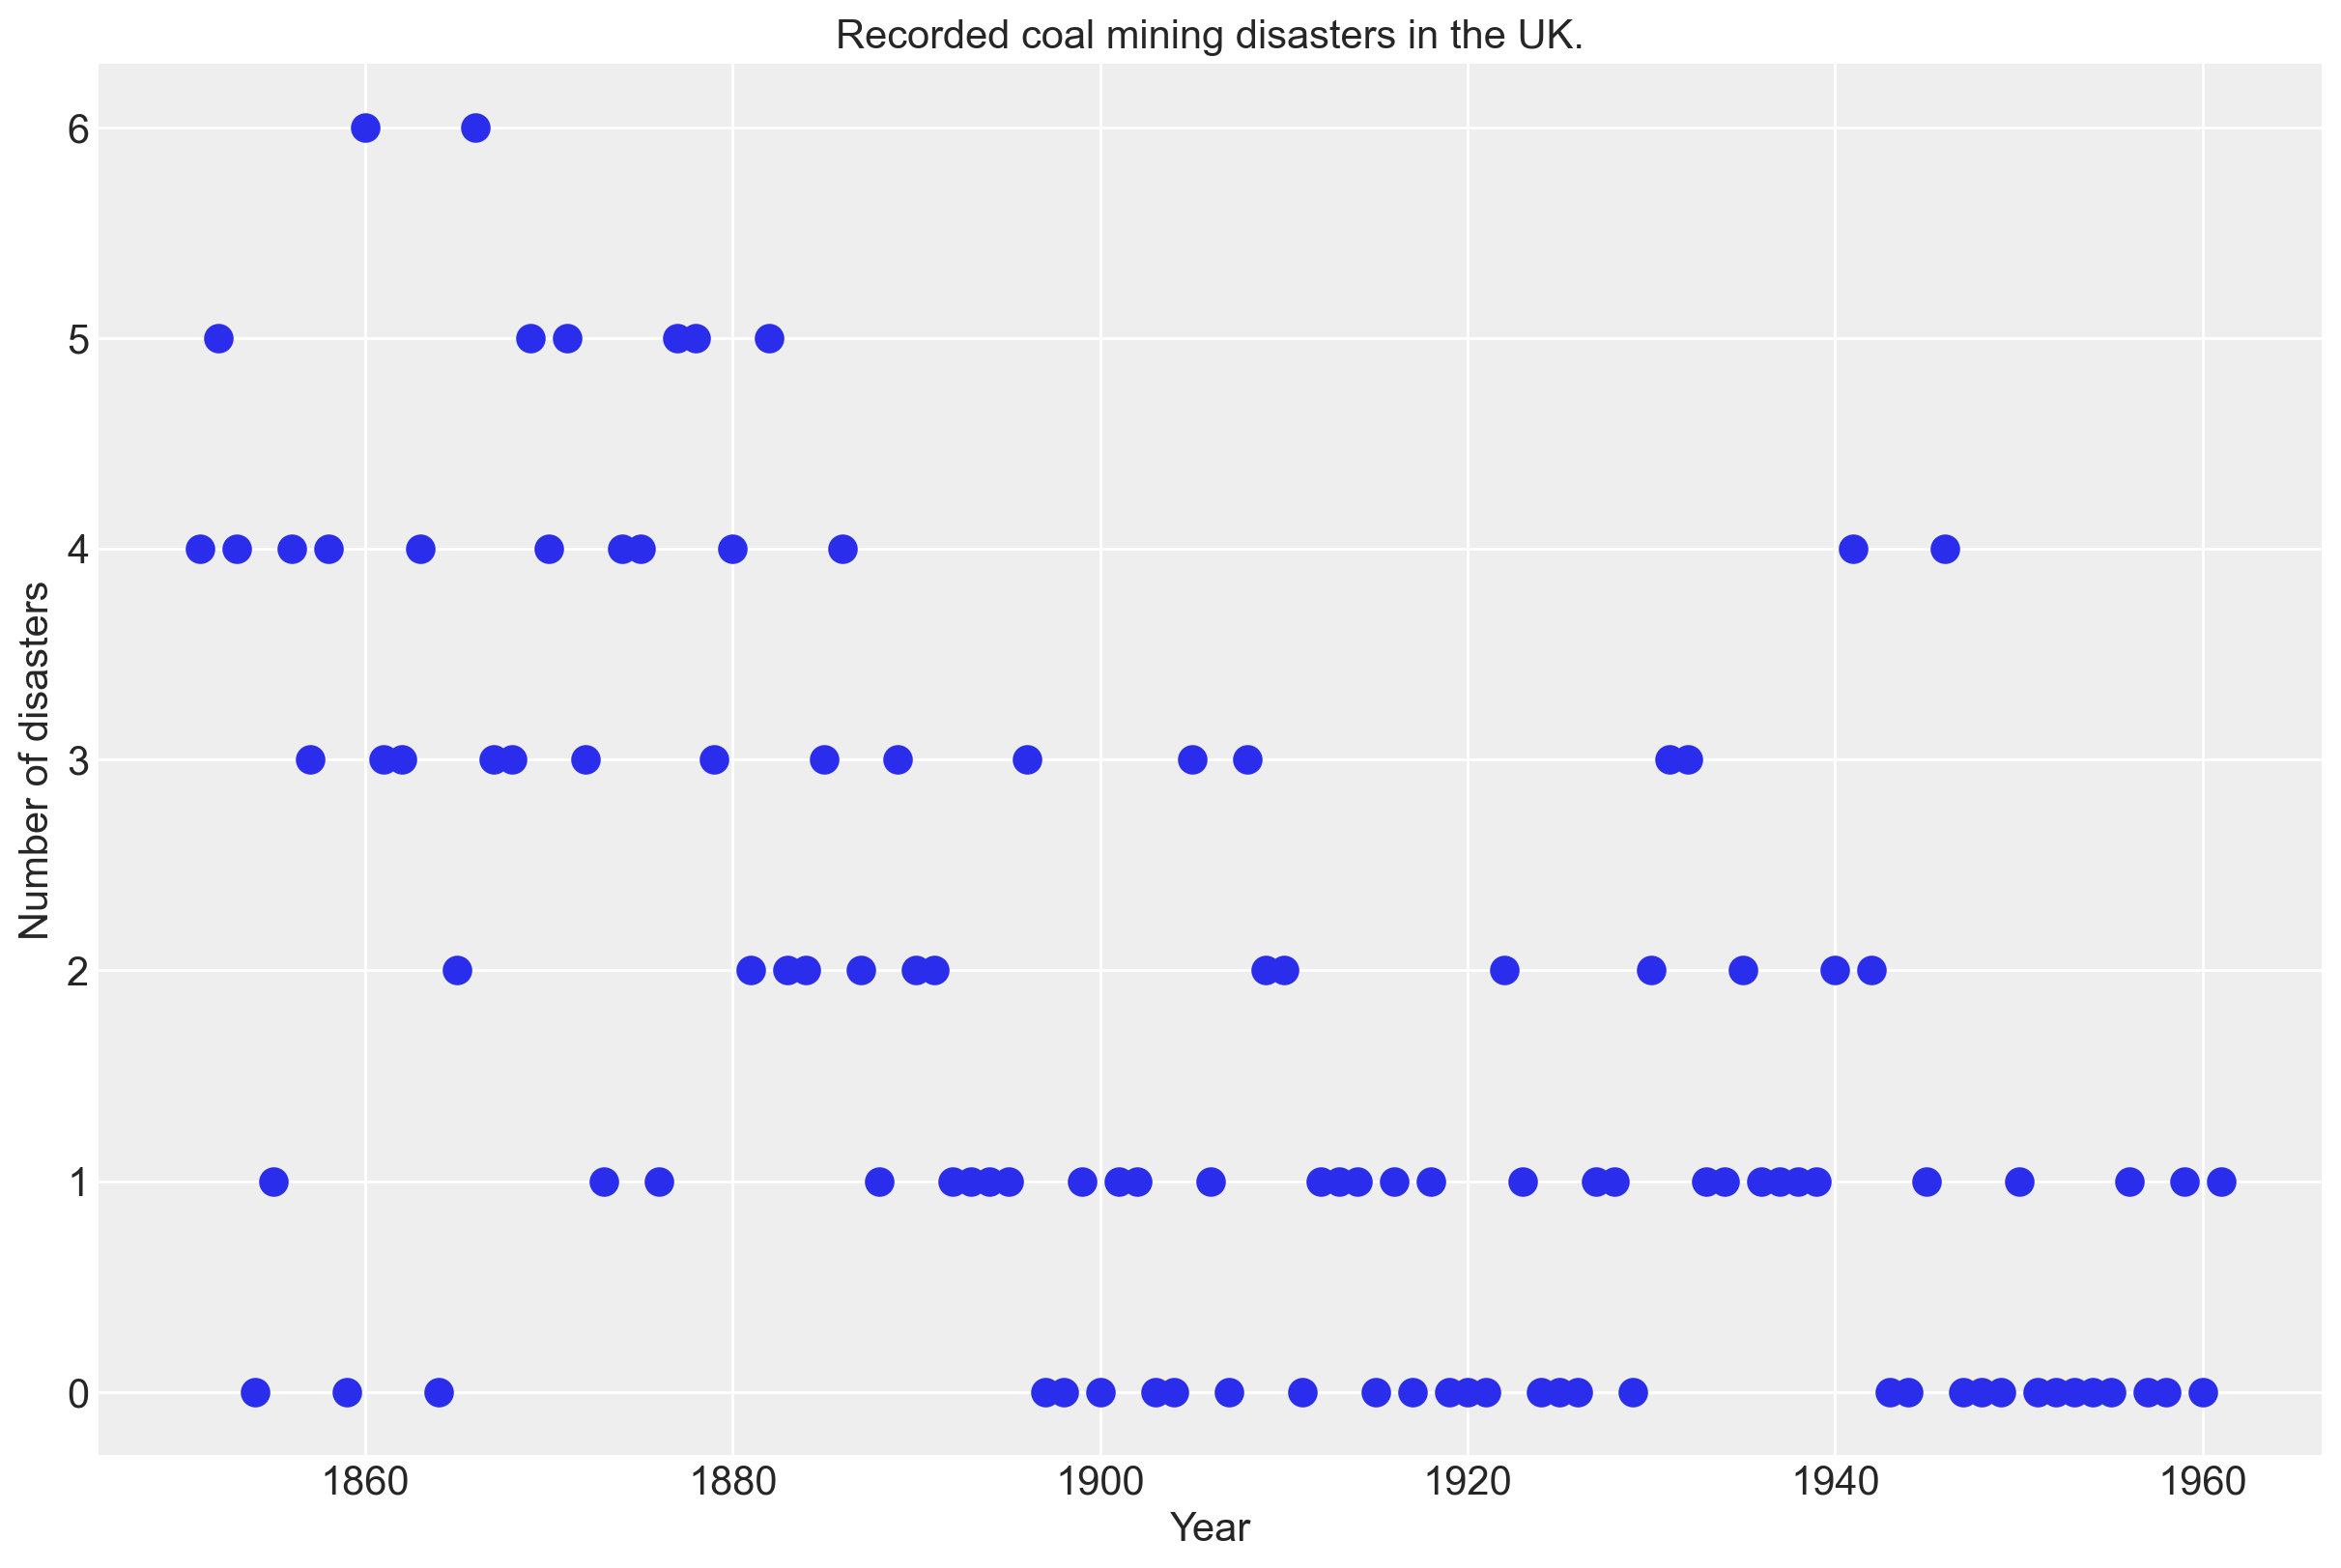

In [5]:
plt.figure(figsize=(12, 8))
plt.plot(disaster_data.year, disaster_data.disasters, 'o', markersize=10)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of disasters', fontsize=15)
plt.title('Recorded coal mining disasters in the UK.', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

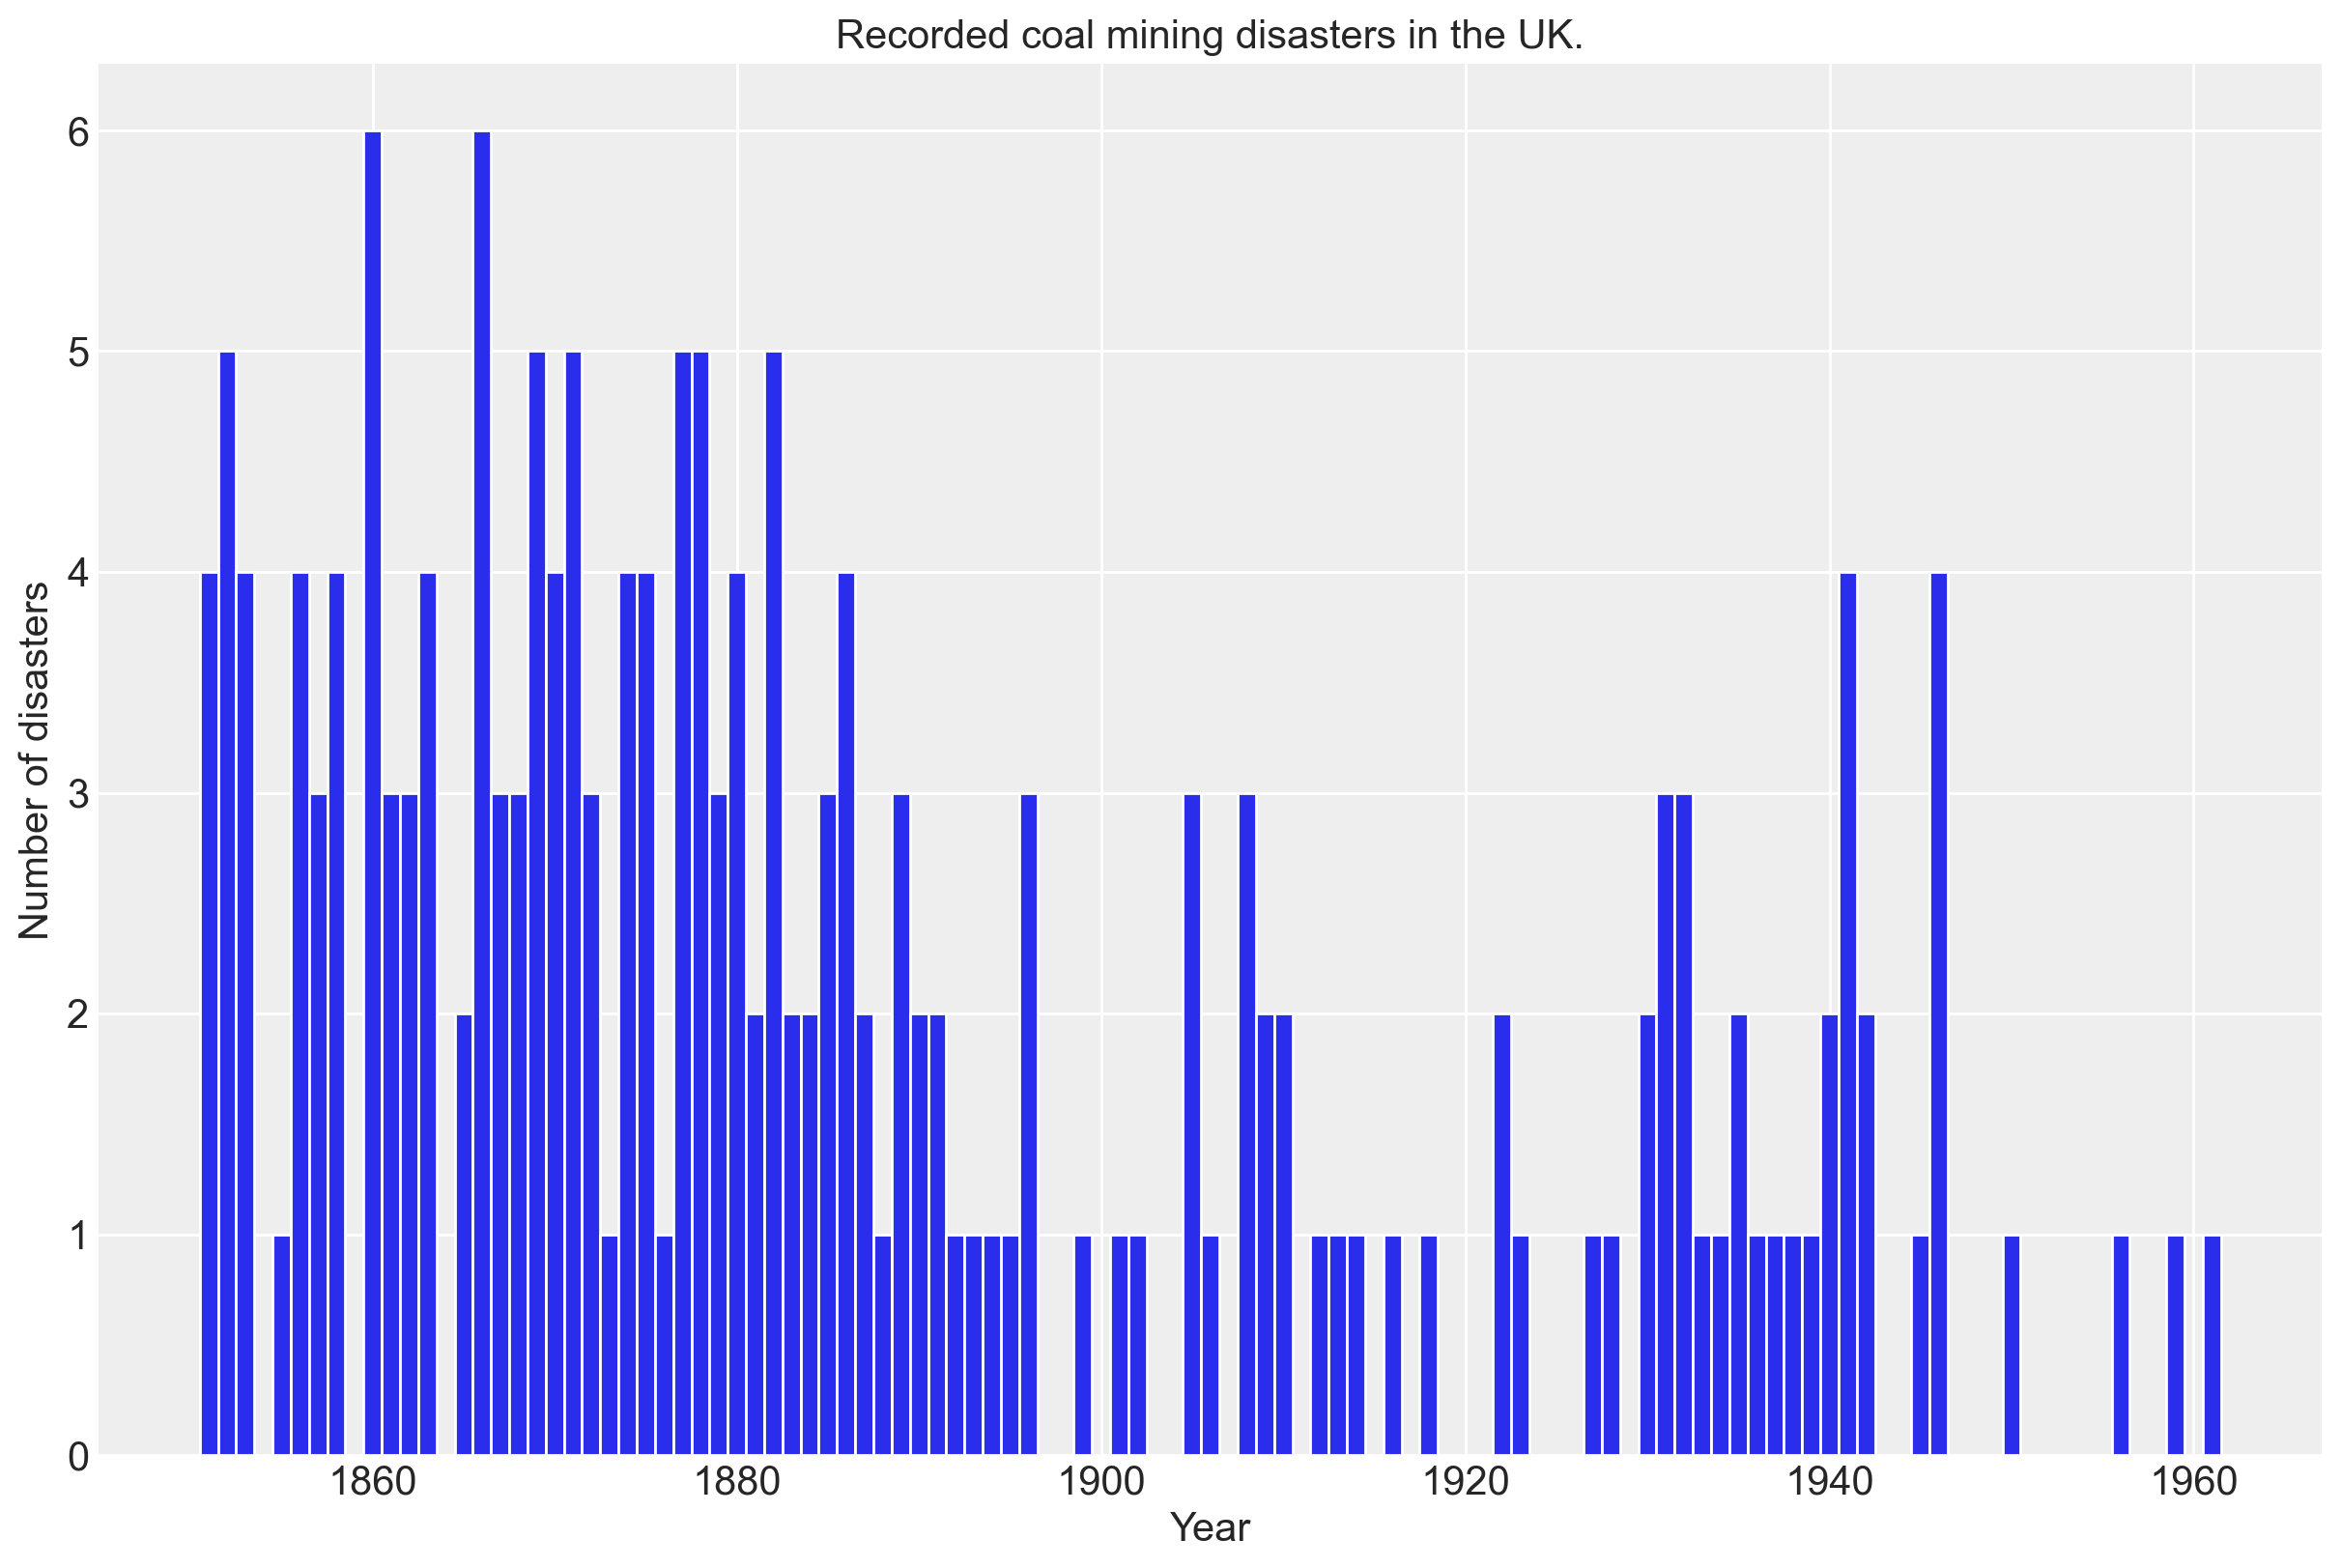

In [6]:
plt.figure(figsize=(12, 8))
bp = plt.bar(disaster_data.year, disaster_data.disasters, width=1.)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Number of disasters", fontsize=15)
plt.title("Recorded coal mining disasters in the UK.", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

### Questions

1. How can we represent this disaster time series data? What are quantities of interests?
2. Is 'disasters' variable categorial or continous? Can it be negative? What are some other constraints?

### Information about the dataset 

Occurrences of disasters in the time series is thought to be derived from a Poisson process with a large rate parameter in the early part of the time series (more disasters in early years), and from one with a smaller rate in the later part (less number of disasters in later years). We are interested in locating the change point in the series, which might be because of changes in mining safety regulations in latter years.

### Modeling Approach

How are we going to develop model for this data? A good starting point would be to think about *how this data might be generated?* Try to imagine how you would recreate the dataset. We begin by asking how our observations might have been generated.

1. We start by thinking "what is the best random variable to describe this count data?" A Poisson random variable is a good candidate because it can represent count data. So we model the number of coal mining related disasters as sampled from a Poisson distribution.

2. Next, we think, "Ok, assuming number of disasters are Poisson-distributed, what do I need for the Poisson distribution?" Well, the Poisson distribution has a rate parameter $\lambda$. 

3.  Do we know $\lambda$? No. In fact, we have a suspicion that there are *two* $\lambda$ values, one for the earlier years and one for the later years. We don't know when the change in this rate parameter occurs though, but call the switchpoint $\tau$.

4. What is a good distribution for the two $\lambda$s? The exponential is good, as it assigns probabilities to positive real numbers. Well the exponential distribution has a parameter too, call it $\alpha$.

5.  Do we know what the parameter $\alpha$ might be? No. At this point, we could continue and assign a distribution to $\alpha$, but it's better to stop once we reach a set level of ignorance: whereas we have a prior belief about $\lambda$, ("it probably changes over time", "it's likely between 1 and 3", etc.), we don't really have any strong beliefs about $\alpha$. So it's best to stop here. 

    What is a good value for $\alpha$ then? We think that the $\lambda$s are between 1-3, so if we set $\alpha$ really low (which corresponds to larger probability on high values) we are not reflecting our prior well. Similar, a too-high alpha misses our prior belief as well. A good idea for $\alpha$ as to reflect our belief is to set the value so that the mean of $\lambda$, given $\alpha$, is equal to our observed mean. 

6. We have no expert opinion of when $\tau$ might have occurred. So we will suppose $\tau$ is from a discrete uniform distribution over the entire timespan.

Here's a graphical model describing the relationships between the variables in our model:

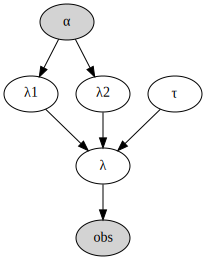

In [7]:
from graphviz import Digraph

gcp = Digraph('coal_mining_disasters_model')

# define the nodes 
gcp.node('alpha', label='<&alpha;>', style='filled')
gcp.node('tau', label='<&tau;>')
gcp.node('lambda_1', label='<&lambda;<sub>1</sub>>')
gcp.node('lambda_2', label='<&lambda;<sub>2</sub>>')
gcp.node('lambda', label='<&lambda;>')
gcp.node('tau', label='<&tau;>')
gcp.node('obs', label='obs', style='filled')

# define the edges 
gcp.edge('alpha', 'lambda_1')
gcp.edge('alpha', 'lambda_2')
gcp.edge('tau', 'lambda')
gcp.edge('lambda_1', 'lambda')
gcp.edge('lambda_2', 'lambda')
gcp.edge('lambda', 'obs')
gcp

More formally, the generative model is expressed as:

$$\lambda_1 \sim \mathrm{Exp}(\lambda_1 | \alpha),$$

$$\lambda_2 \sim \mathrm{Exp}(\lambda_2 | \alpha),$$

$$ \tau \sim \mathrm{DiscreteUniform}([1851, 1852, \dots, 1961]), $$

$$\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}$$
$$\mathrm{obs}_i \sim \mathrm{Poisson}(\lambda_i)$$

We will set the rate parameter $\alpha$ on the exponential priors on $\lambda_1$ and $\lambda_2$ as a constant. 
The latent variables to be inferred are $\lambda_1, \lambda_2, \tau$.

### `PyMC3` model 

In [8]:
disaster_model = pm.Model()
lower_year, upper_year = years.min(), years.max()
alpha = 1.

with disaster_model:
    # define the prior 
    lambda_1 = pm.Exponential("lambda_1", lam=alpha)
    lambda_2 = pm.Exponential("lambda_2", lam=alpha)
    tau      = pm.DiscreteUniform('tau', lower=lower_year, upper=upper_year)
    lmbda = pm.Deterministic('lambda', tt.switch(tau >= years, lambda_1, lambda_2))
    
    # define the likelihood 
    x = pm.Poisson('x', lmbda, observed=disasters)

### Inference and posterior visualization

Now let's infer the hidden parameters with MCMC. 
The Gibbs sampler is operating on the background along with a different Metropolis-Hastings algorithm associated with each parameter.

In [9]:
with disaster_model:
    trace = pm.sample(draws=40000, progressbar=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]


/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


/var/folders/5y/28n32xmx0551k29hd21qs87c0000gp/T/ipykernel_43649/4119530376.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  _=pm.traceplot(trace, var_names=['tau', 'lambda_1', 'lambda_2'])
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


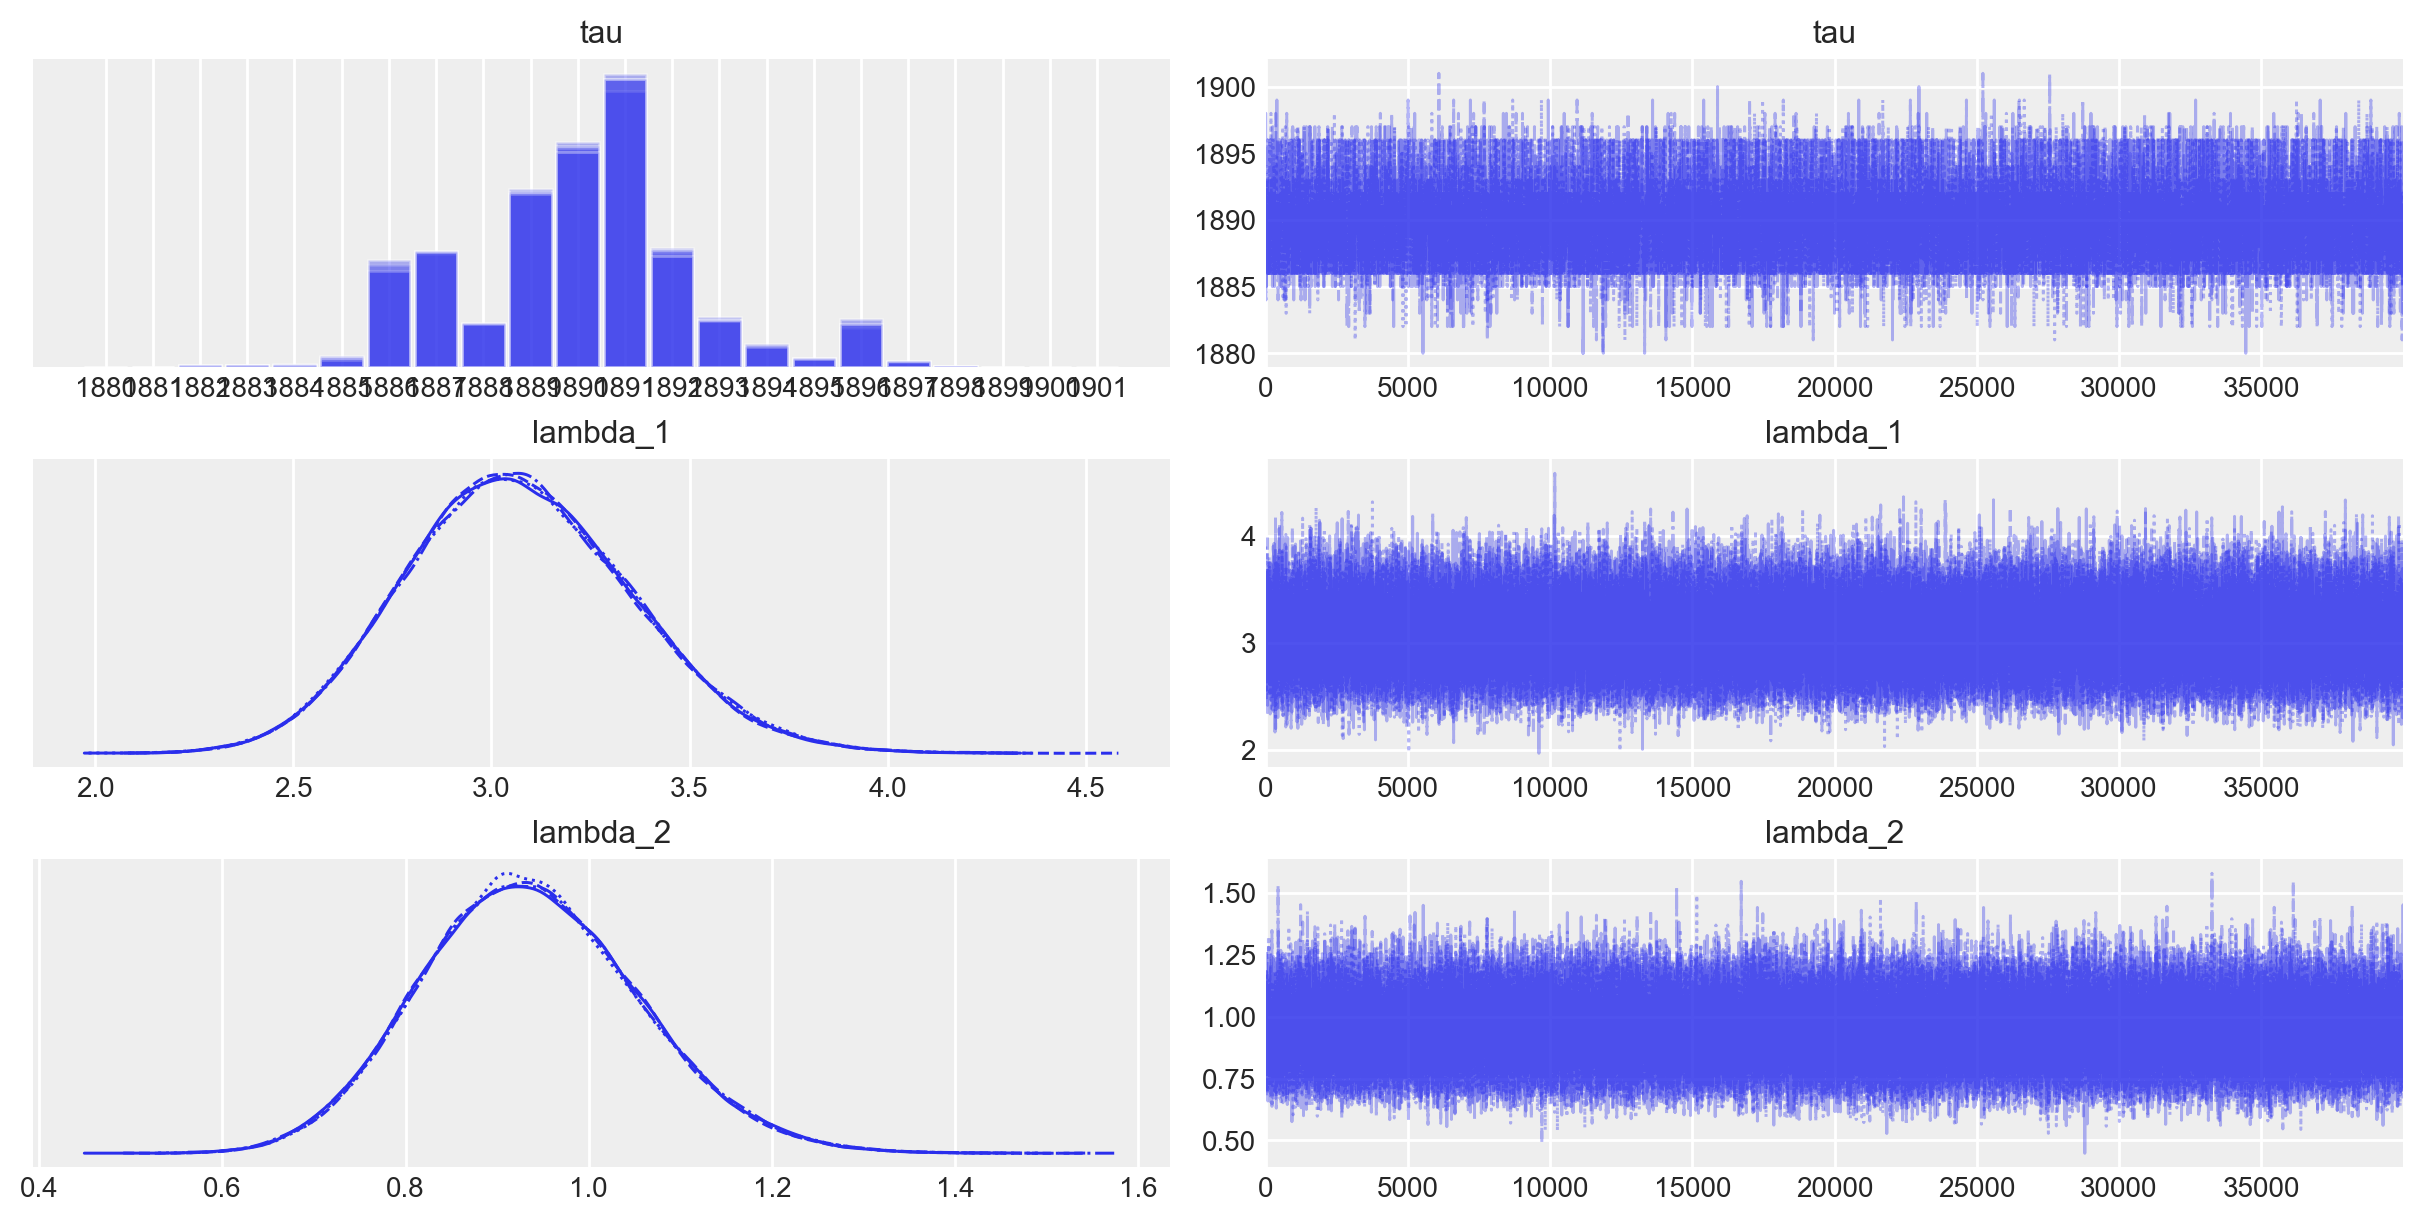

In [10]:
_=pm.traceplot(trace, var_names=['tau', 'lambda_1', 'lambda_2'])

Got error No model on context stack. trying to find log_likelihood in translation.


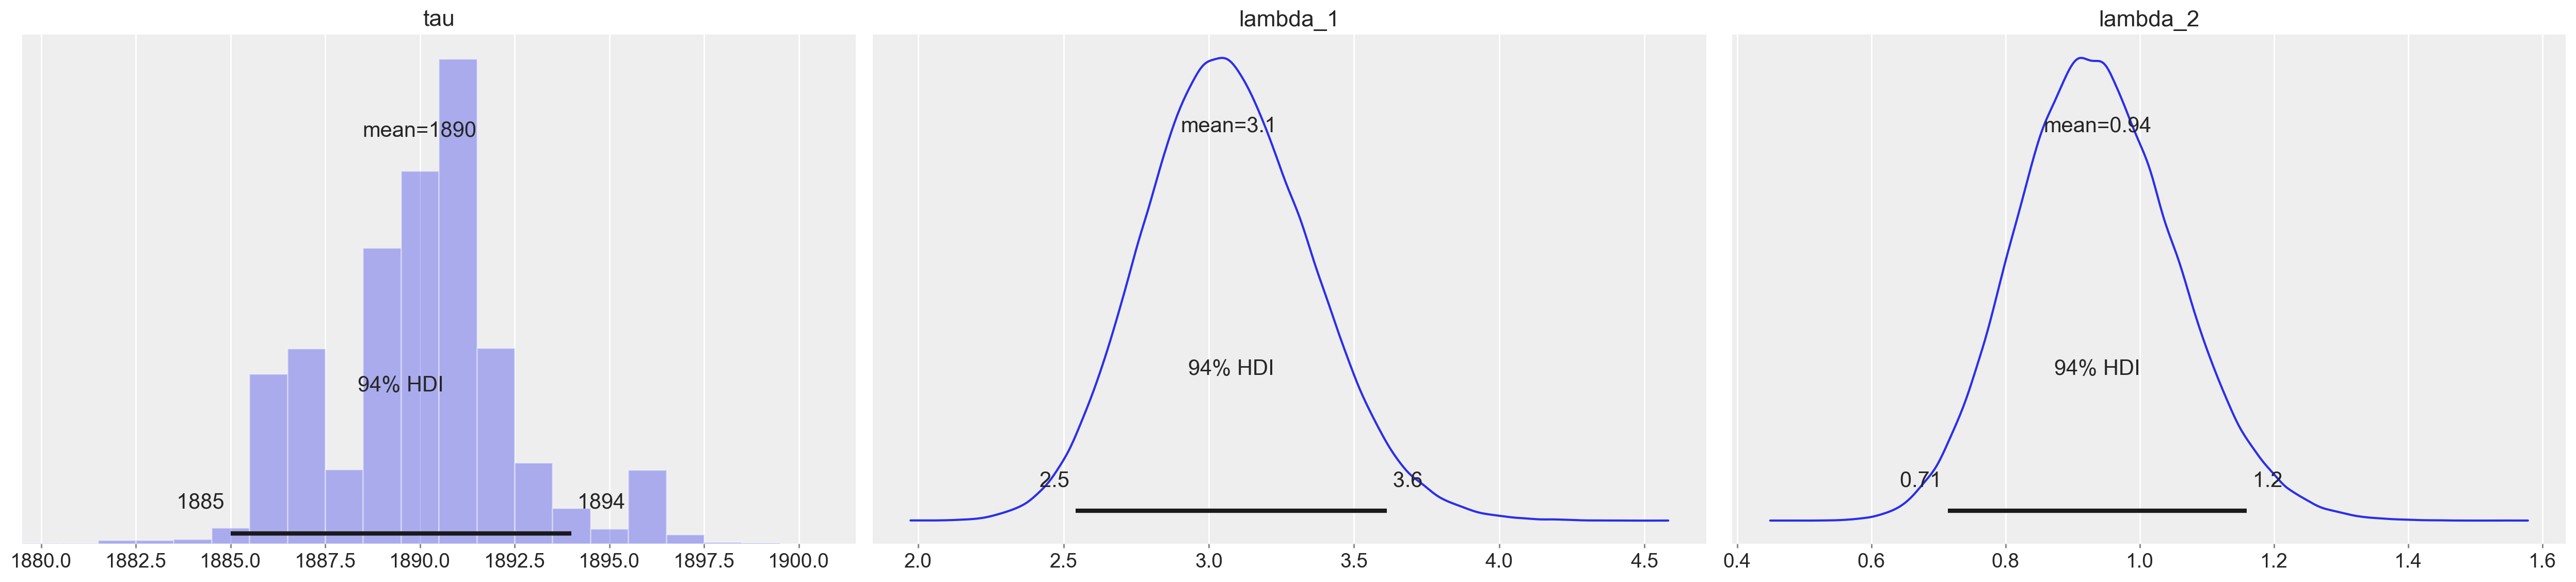

In [14]:
_=pm.plot_posterior(trace, var_names=['tau', 'lambda_1', 'lambda_2'])

Got error No model on context stack. trying to find log_likelihood in translation.


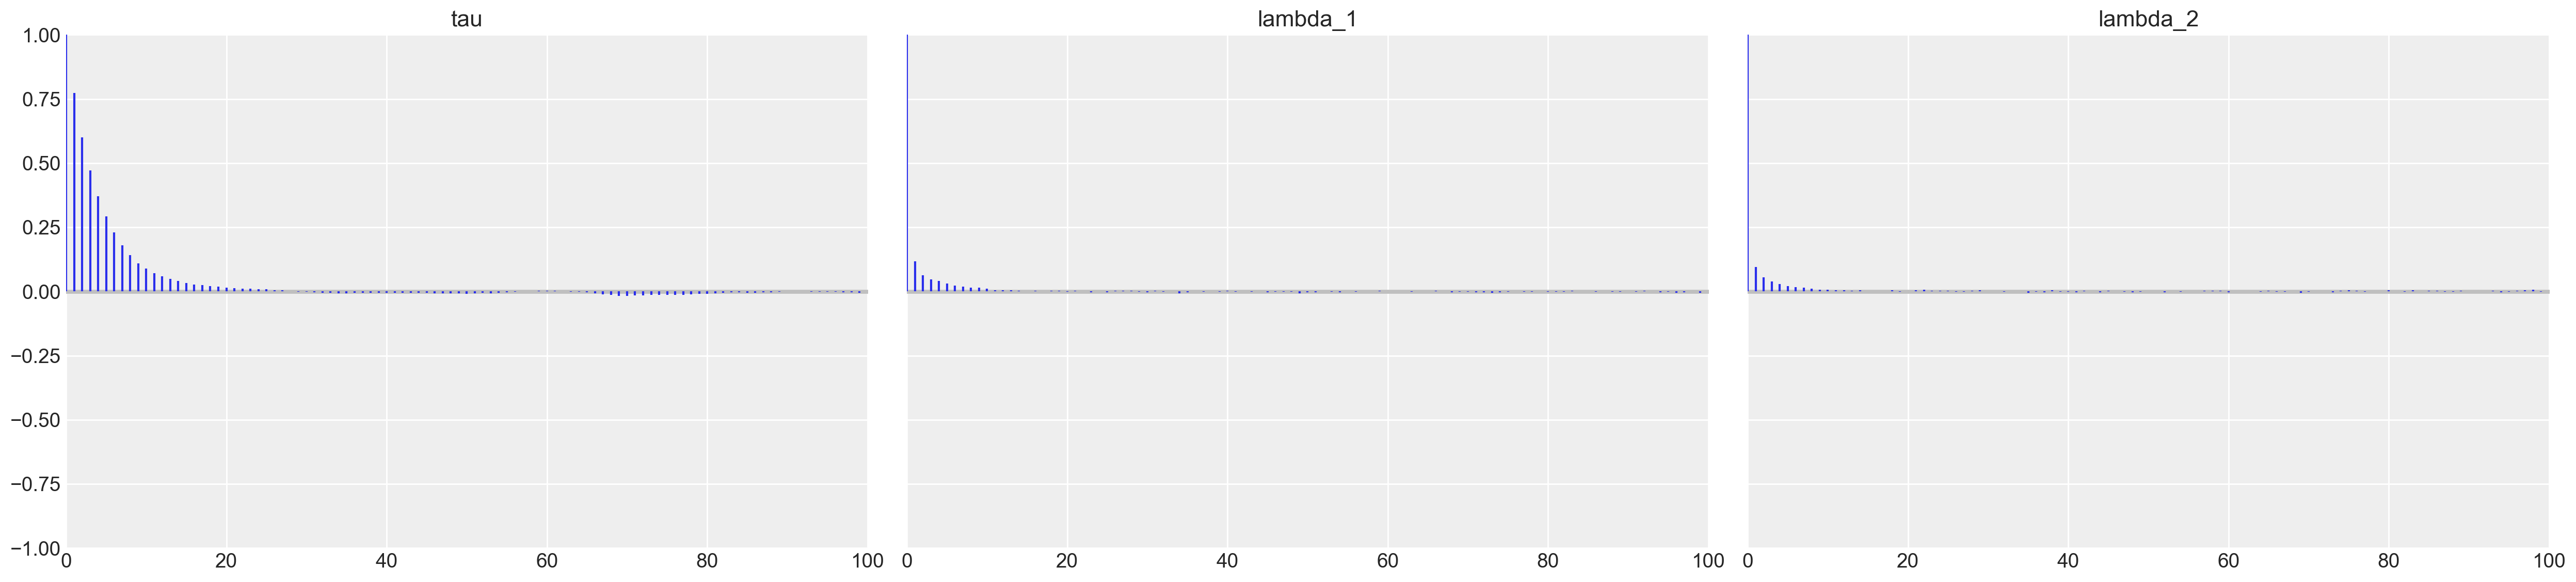

In [12]:
_=pm.plot_autocorr(trace, var_names=['tau','lambda_1', 'lambda_2'], combined=True)

Got error No model on context stack. trying to find log_likelihood in translation.


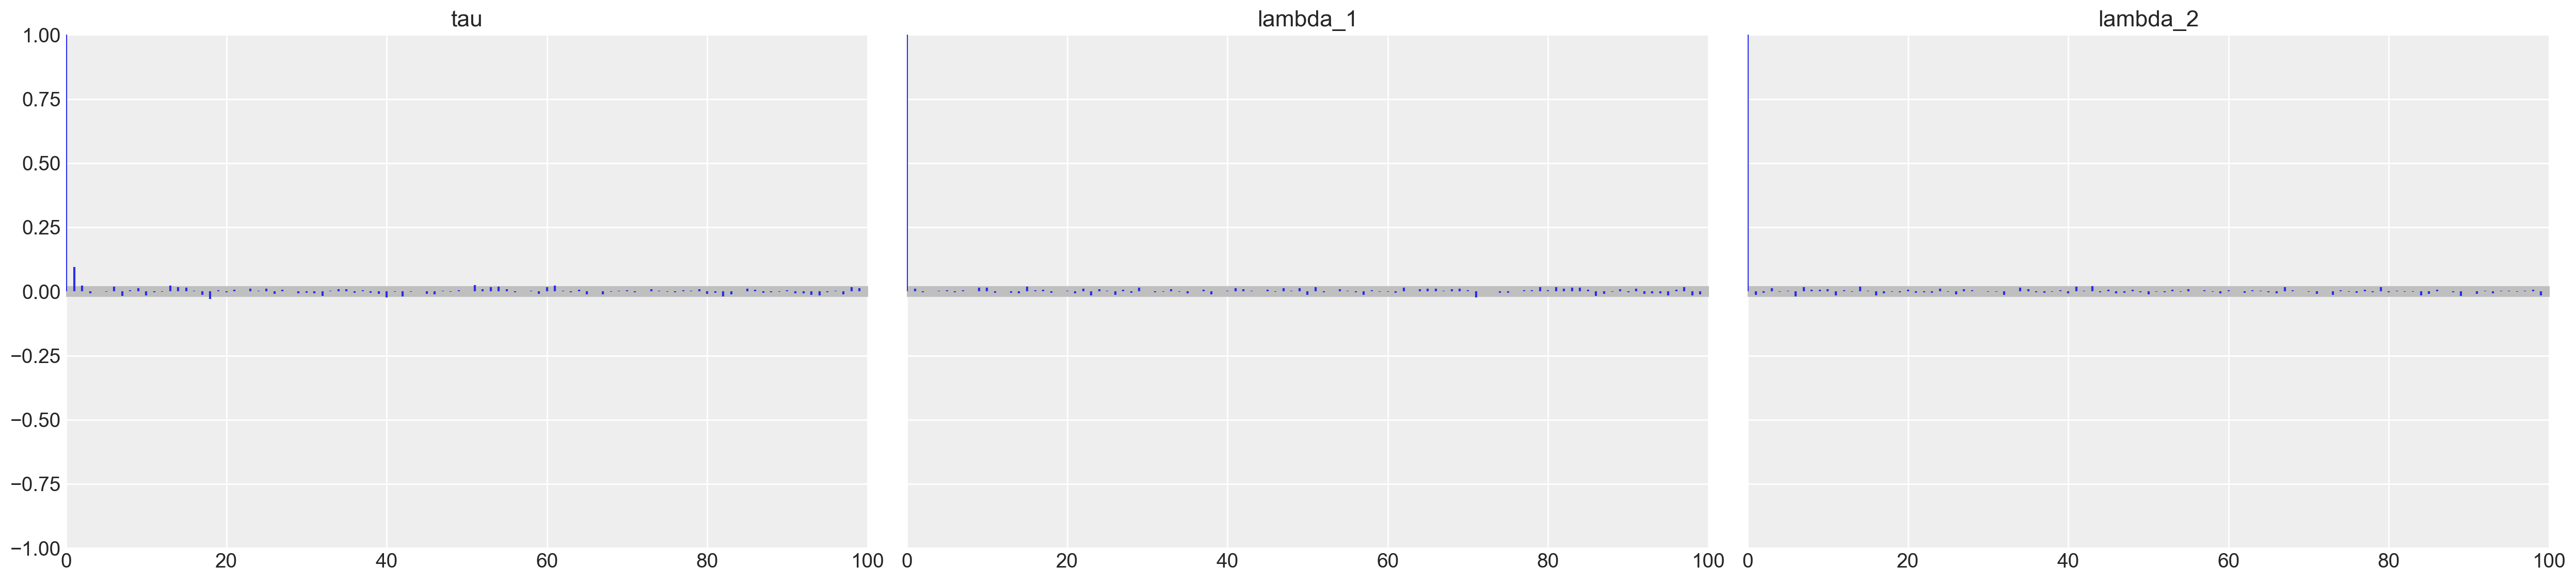

In [13]:
thinned_trace = trace[10000::10]
_=pm.plot_autocorr(thinned_trace, var_names=['tau', 'lambda_1', 'lambda_2'], combined=True)

/var/folders/5y/28n32xmx0551k29hd21qs87c0000gp/T/ipykernel_43649/191797834.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(thinned_trace, var_names=['tau', 'lambda_1', 'lambda_2']);
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


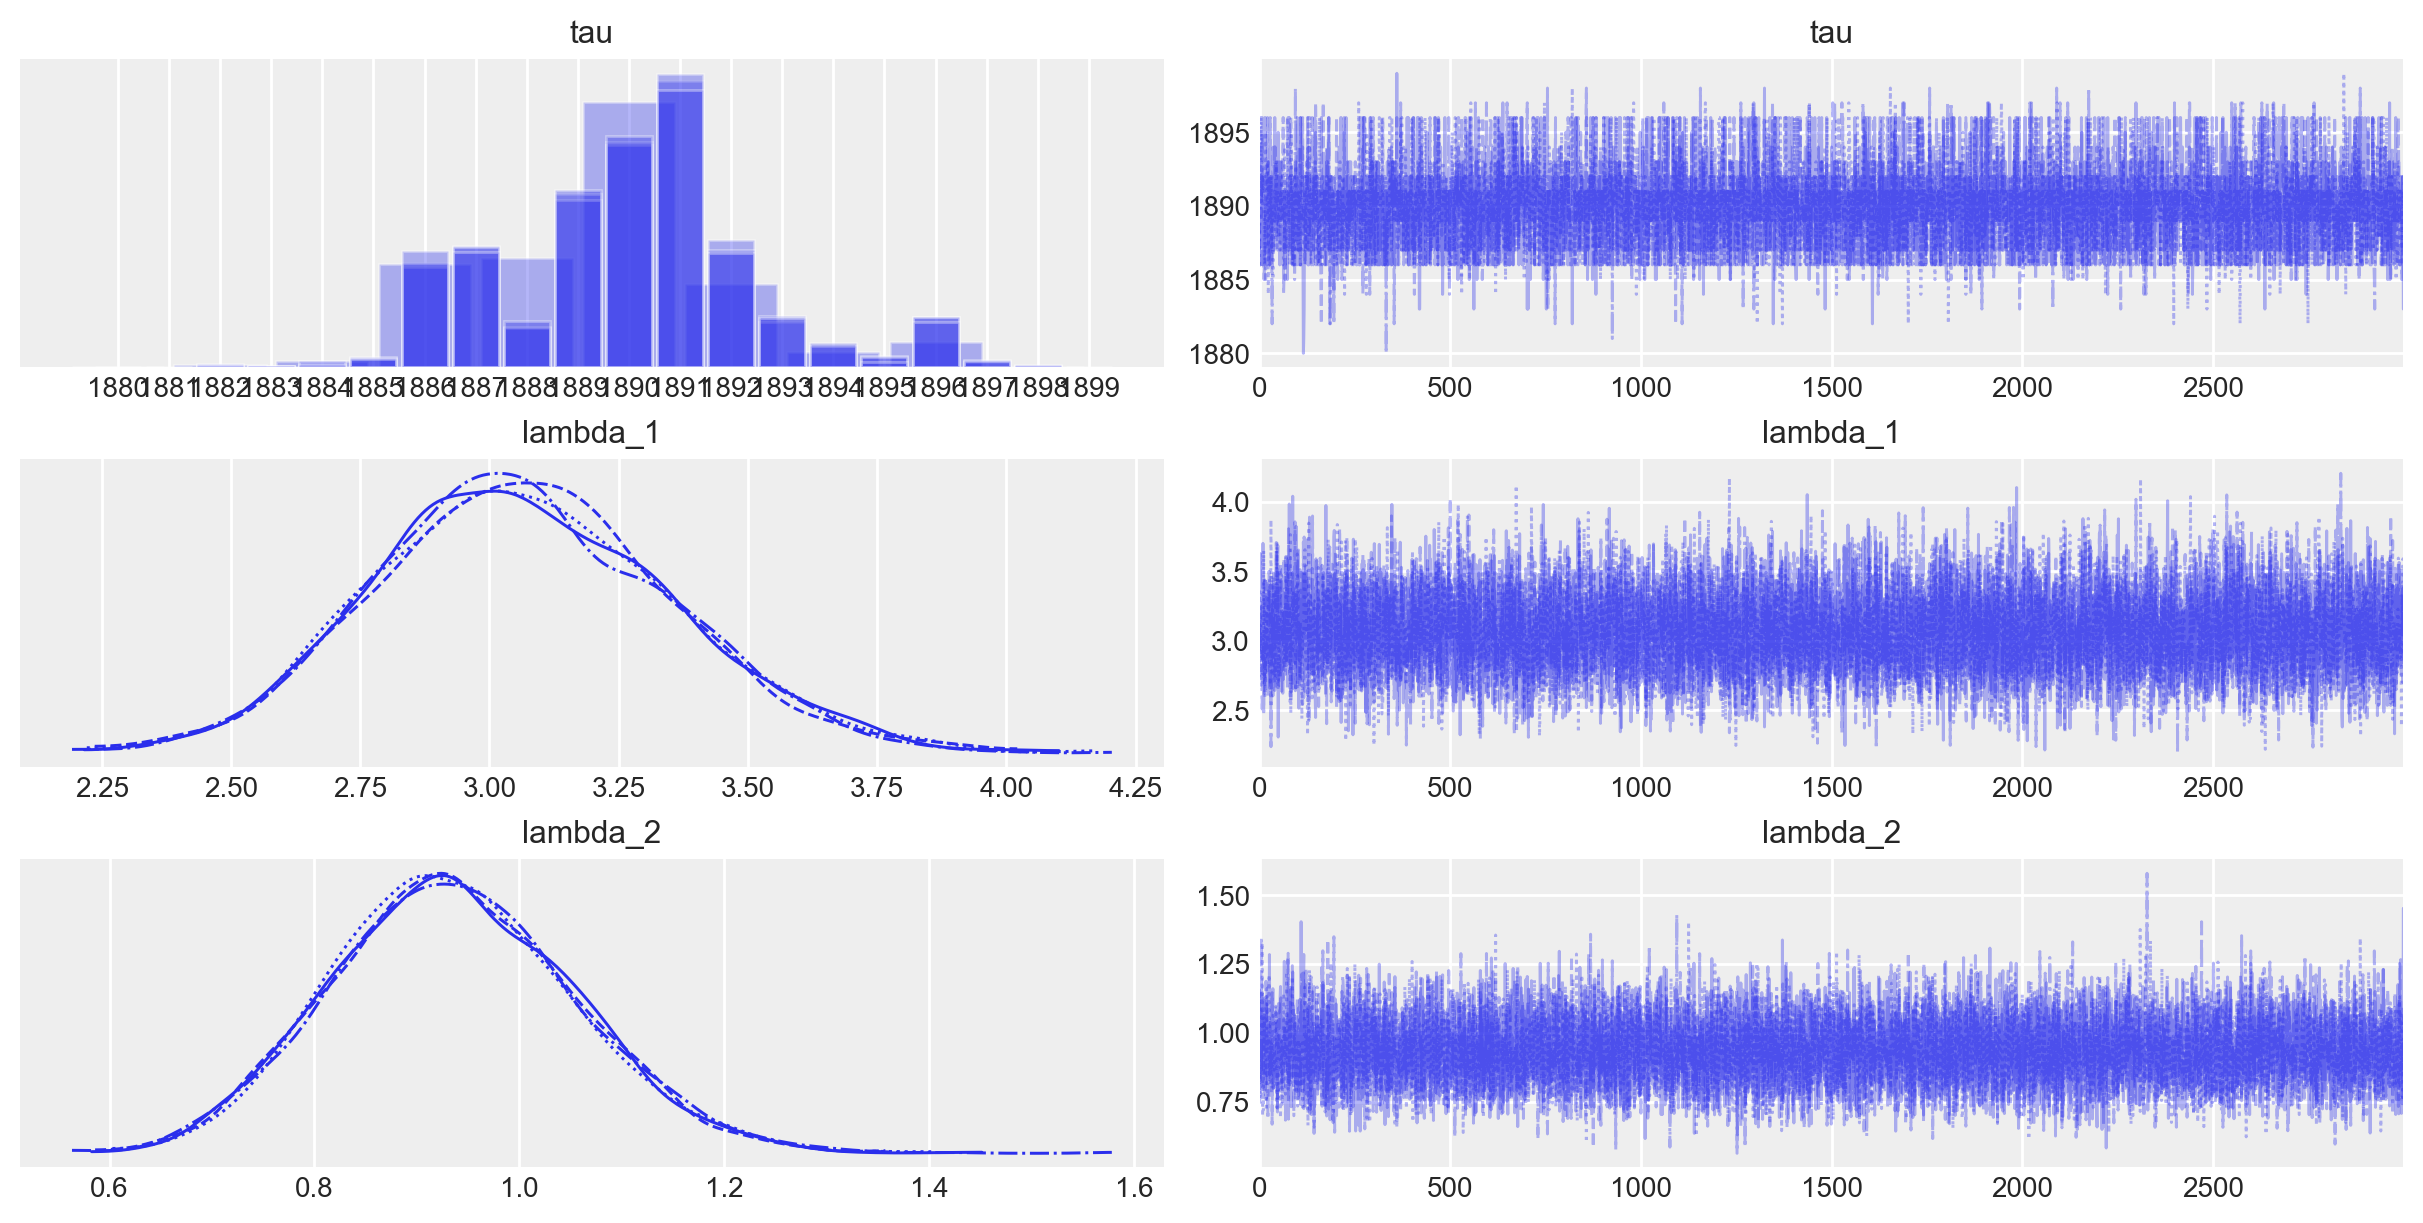

In [15]:
pm.traceplot(thinned_trace, var_names=['tau', 'lambda_1', 'lambda_2']);

We can now use the samples from the posterior of the unknown parameters in this model to estimate the expected number of disasters between $t = 1851$ and $t=1962$. 

/opt/homebrew/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


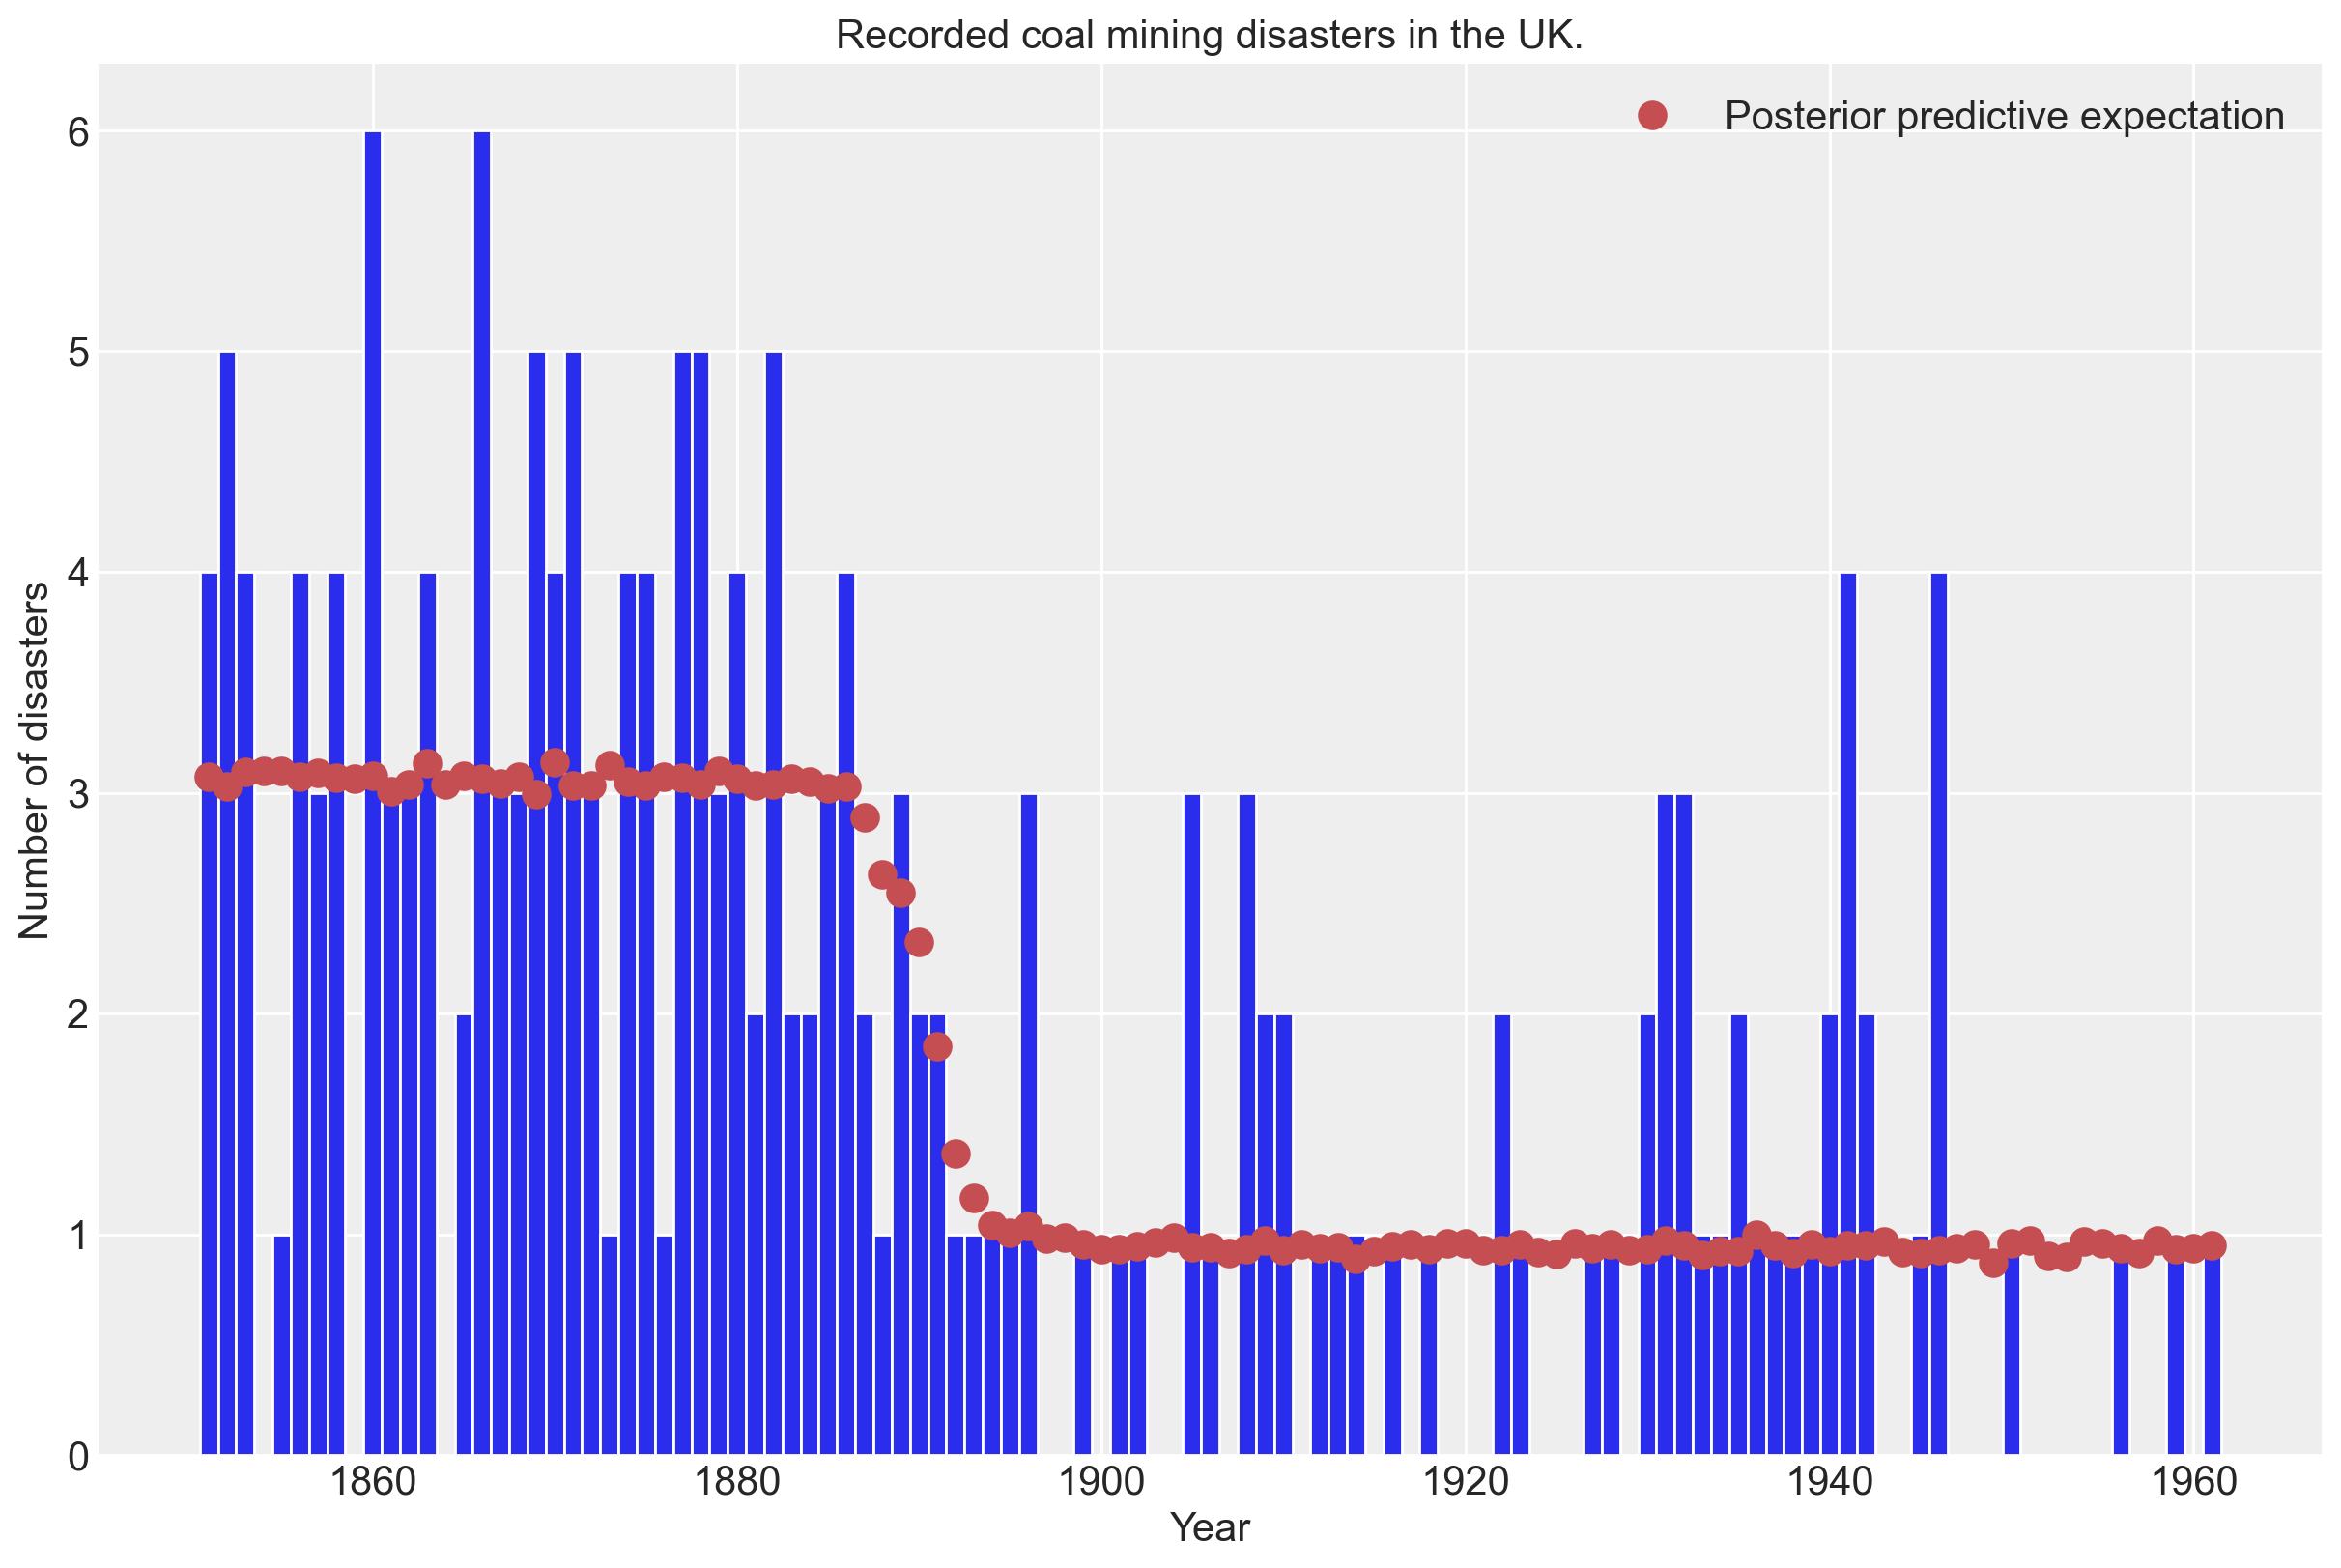

In [16]:
ppsamples = pm.sample_posterior_predictive(samples=2000, 
                                           model=disaster_model, 
                                           trace=thinned_trace)['x']
plt.figure(figsize=(12, 8))
bp = plt.bar(disaster_data.year, disaster_data.disasters, width=1.)
plt.plot(disaster_data.year, ppsamples.mean(axis=0), 'ro', 
         markersize=10, label='Posterior predictive expectation')
plt.xlabel("Year", fontsize=15)
plt.ylabel("Number of disasters", fontsize=15)
plt.title("Recorded coal mining disasters in the UK.", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best', fontsize=15)

## Real Data Example 2 - Challenger Space Shuttle Disaster

For this tutorial, we are going to work on Challenger space shuttle disaster dataset.
We have revisited the problem in [HW 5](https://colab.research.google.com/github/PredictiveScienceLab/data-analytics-se/blob/master/homework/homework_05.ipynb). There, we used logistic regression and we trained it with maximum likelihood.
We can now follow a Bayesian approach to the fullest extent.

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. The data are shown below:

In [17]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/challenger_data.csv"
download(url)

In [18]:
challenger_data = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]
print("Temp (F), O-Ring failure?")
print(challenger_data)

Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


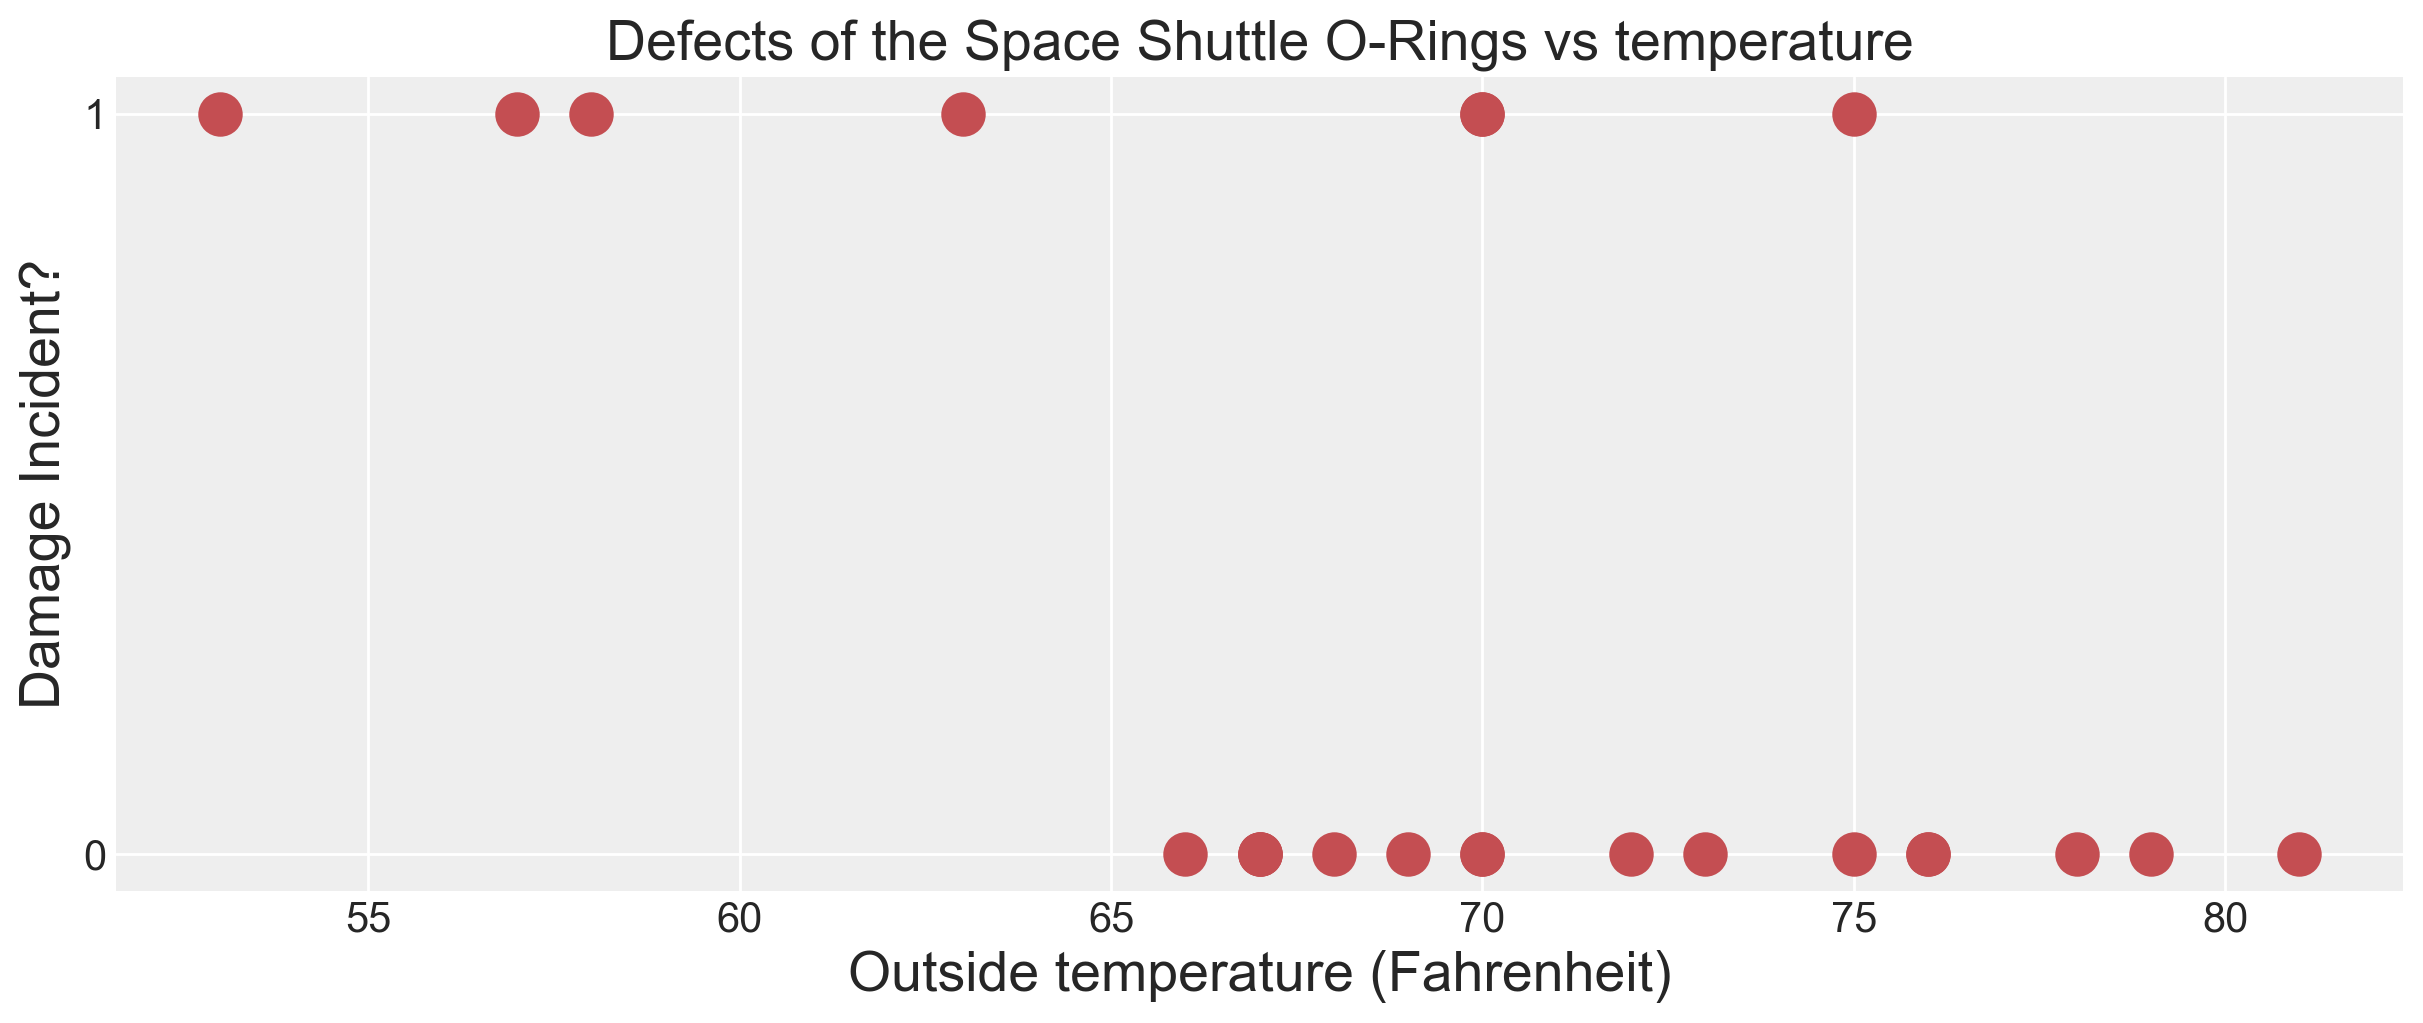

In [19]:
# plot it, as a function of temperature (the first column)
plt.figure(figsize=(12, 5))
plt.plot(challenger_data[:, 0], challenger_data[:, 1], 'ro', 
         markersize=15)
plt.ylabel("Damage Incident?",fontsize=20)
plt.xlabel("Outside temperature (Fahrenheit)",fontsize=20)
plt.title("Defects of the Space Shuttle O-Rings vs temperature",
          fontsize=20)
plt.yticks([0, 1], fontsize=15)
plt.xticks(fontsize=15);

### Information about the dataset 
It looks clear that *the probability* of damage incidents occurring increases as the outside temperature decreases. We are interested in modeling the probability here because it does not look like there is a strict cutoff point between temperature and a damage incident occurring. The best we can do is ask "At temperature $t$, what is the probability of a damage incident?". The goal of this example is to answer that question.

### Questions

1. How can we represent this disaster binary 1/0 data? What are quantities of interests?
2. Is 'damage incident' variable categorial or continous? What are some other constraints?

### Modeling approach

How are we going to develop model for this data? A good starting point would be to think about *how this data might be generated?* Try to imagine how you would recreate the dataset. We begin by asking how our observations might have been generated.

- We start by thinking "what is the best random variable to describe this binary categorical data?" A Bernoulli random variable is a good candidate because it can represent binary data. So we model the variable of 'damage incident' as sampled from a Bernoulli distribution. A *Bernoulli* random variable with parameter $p$, denoted $\text{Ber}(p)$, is a random variable that takes value 1 with probability $p$, and 0 else. Thus, our model can look like:

$$ \text{Defect Incident, $D_i$} \sim \text{Ber}( \;p_i\; ), \;\; i=1..N$$

- Next, we think, "Ok, assuming damage incident variable is Bernoulli-distributed, what do I need for the Bernoulli distribution?" Well, the Bernoulli distribution has a probability parameter $p_i$. 

-  Do we know $p_i$ parameter? No. But we have a suspicion (intuition) that this parameter is dependent on outside temperature values. Less the value of outside temperature, more is the probability of damage incident. More the value of outside temperature, less is the probability of damage incident. With slight abuse in notation, we can define this as:

$$p_i = p(t_i) = \sigma(t_i),$$

where $\sigma: \mathbb{R} \rightarrow (0, 1)$ is a suitable function that maps arbitrary temperature values to the interval $(0, 1)$ (so that we can then interpret the output of $\sigma$ as a probability). For this problem, we are going to use logistic link function which is given as:

$$\sigma(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

Some plots are shown below, with differing $\alpha$ and $\beta$ parameter values:

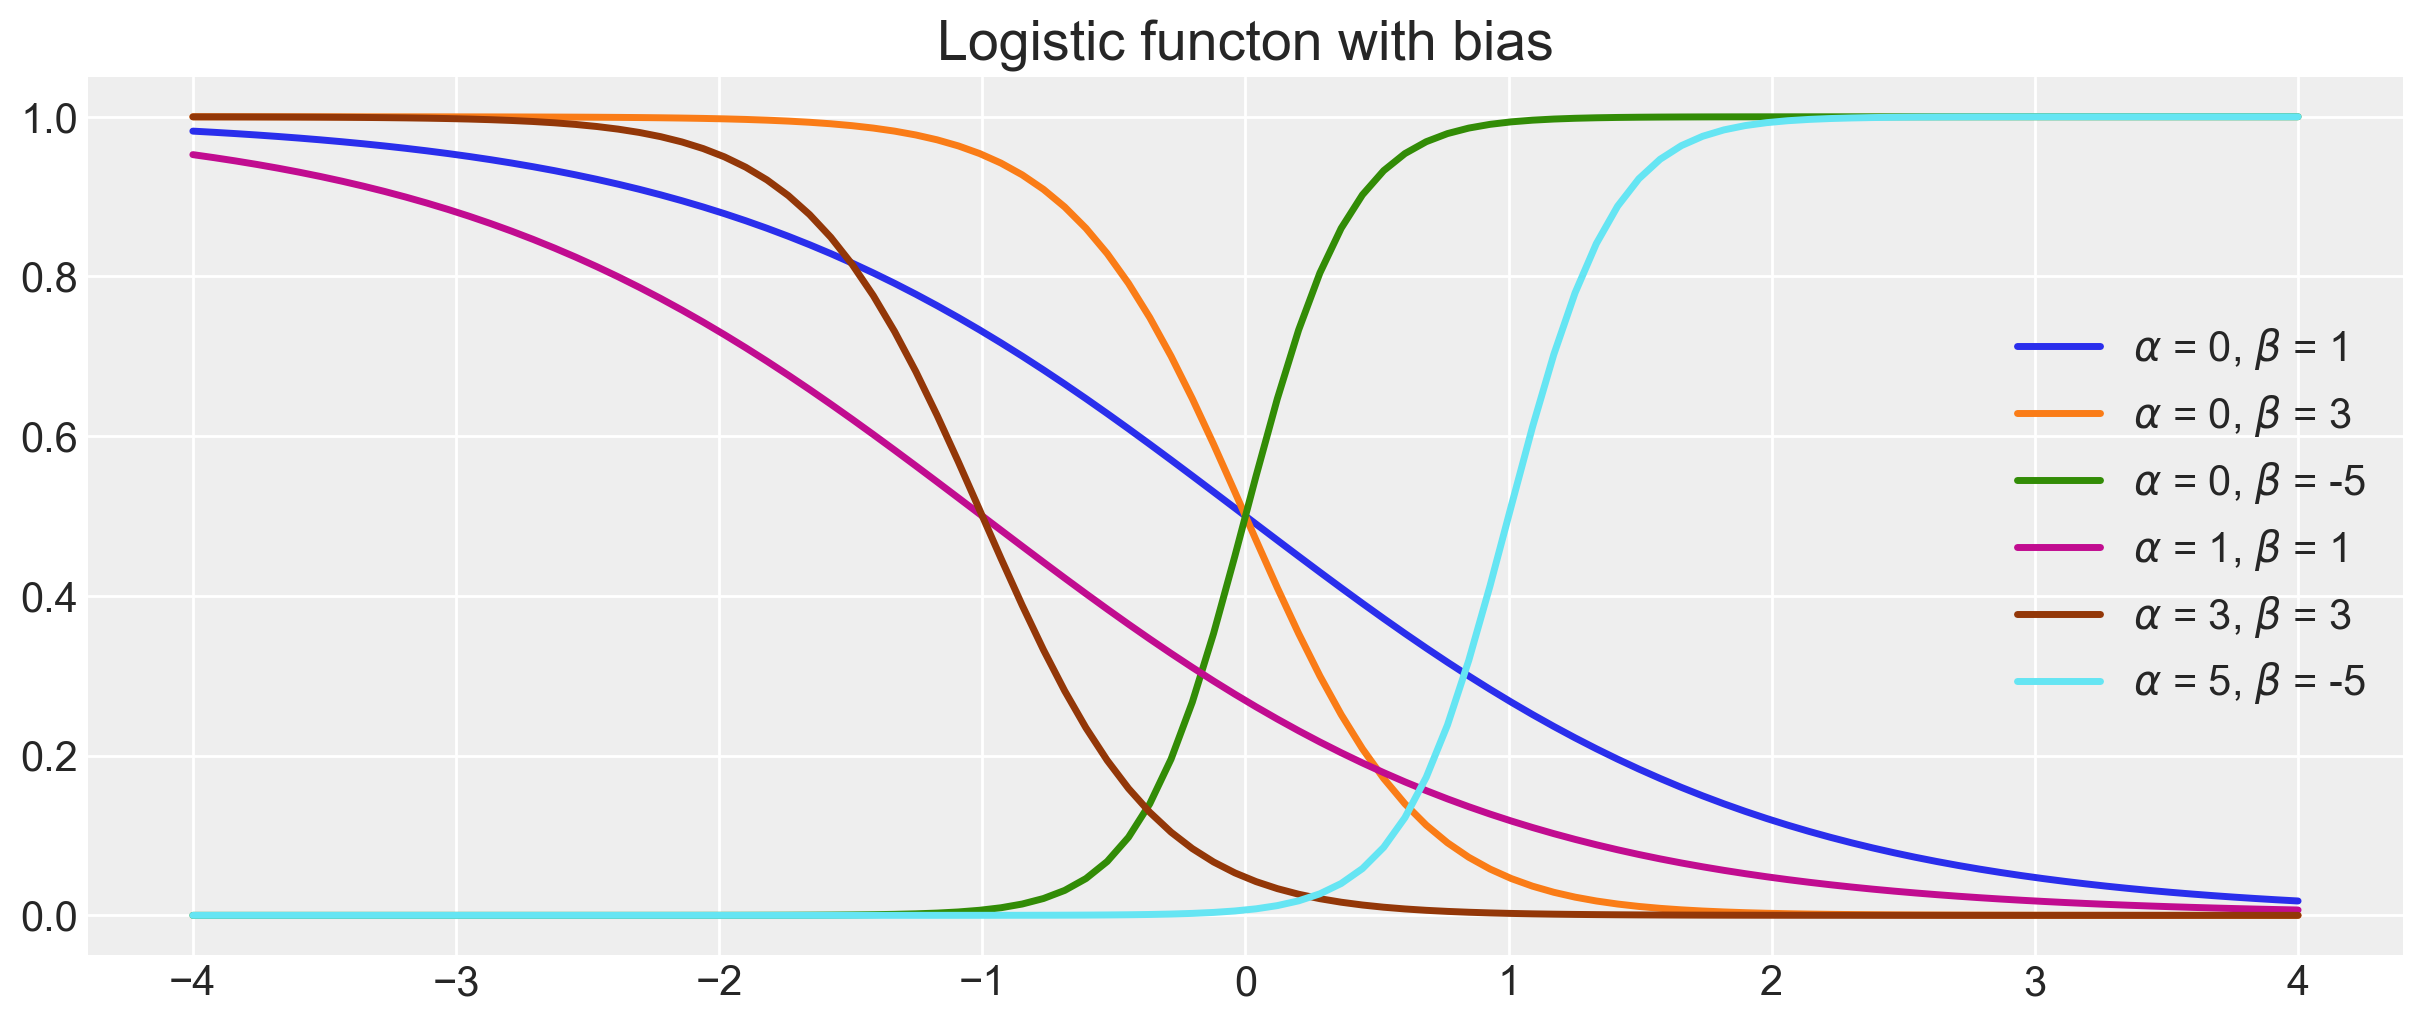

In [20]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)
plt.figure(figsize=(12, 5))
alphas = [0, 0, 0, 1, 3, 5]
betas  = [1, 3, -5, 1, 3, -5]
params = zip(alphas, betas)
for param in params:
    alpha, beta = param
    label="$\\alpha$ = %d, $\\beta$ = %d"%(alpha, beta)
    plt.plot(x, logistic(x, beta, alpha),
             label=label, 
             linewidth=2.5)
plt.title("Logistic functon with bias", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="best", fontsize=15);

#### Question:
__How can we represent  $\alpha$ and $\beta$ parameter values? Are they categorical or continous? Do they need to be positive?__

The $\beta, \alpha$ parameters have no reason to be positive, bounded or relatively large, so they are best modeled by a *Normal random variable*. Since we dont have any prior beliefs about the value of parameters beta or alpha, we place a vague prior Normal distribution (small precision, large variance) over their values.

The graphical model for the data generation process is shown below. 

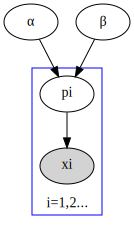

In [21]:
gcp = Digraph('space_shuttle_disaster')

# setup the nodes 
gcp.node('alpha', label='<&alpha;>')
gcp.node('beta', label='<&beta;>')
with gcp.subgraph(name='cluster_0') as sg:
    sg.node('pi', label='<p<sub>i</sub>>')
    sg.node('xi', label='<x<sub>i</sub>>', style='filled')
    sg.attr(color='blue')
    sg.attr(label='i=1,2...')
    sg.attr(labelloc='b')

# setup the edges 
gcp.edge('alpha', 'pi')
gcp.edge('beta', 'pi')
gcp.edge('pi', 'xi')
gcp

### `PyMC3` model 

In [22]:
# gather the data and apply preprocessing if any 
temp = challenger_data[:, 0]
temp_scaled = (temp - np.mean(temp))/np.std(temp)
data = challenger_data[:, 1]

# instantiate the pymc3 model
challenger_model = pm.Model()

# define the graph 
with challenger_model:
    # define the prior
    alpha = pm.Normal('alpha', mu=0., sigma=10.)
    beta = pm.Normal('beta', mu=0., sigma=10.)
    
    # get the probabilities of failure at each observed temp 
    p = pm.Deterministic('p', 1./(1. + tt.exp(alpha + beta*temp_scaled)))
    
    # define the likelihood 
    x = pm.Bernoulli('x', p=p, observed=data)
print("Challenger space shuttle disaster model:")
challenger_model

Challenger space shuttle disaster model:


### Inference and posterior visualization

Now let's infer the hidden parameters with MCMC. We will use the default NUTS sampler. 

In [23]:
with challenger_model:
    trace = pm.sample(draws=40000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 13 seconds.


/var/folders/5y/28n32xmx0551k29hd21qs87c0000gp/T/ipykernel_43649/1817153717.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, var_names=var_names);
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


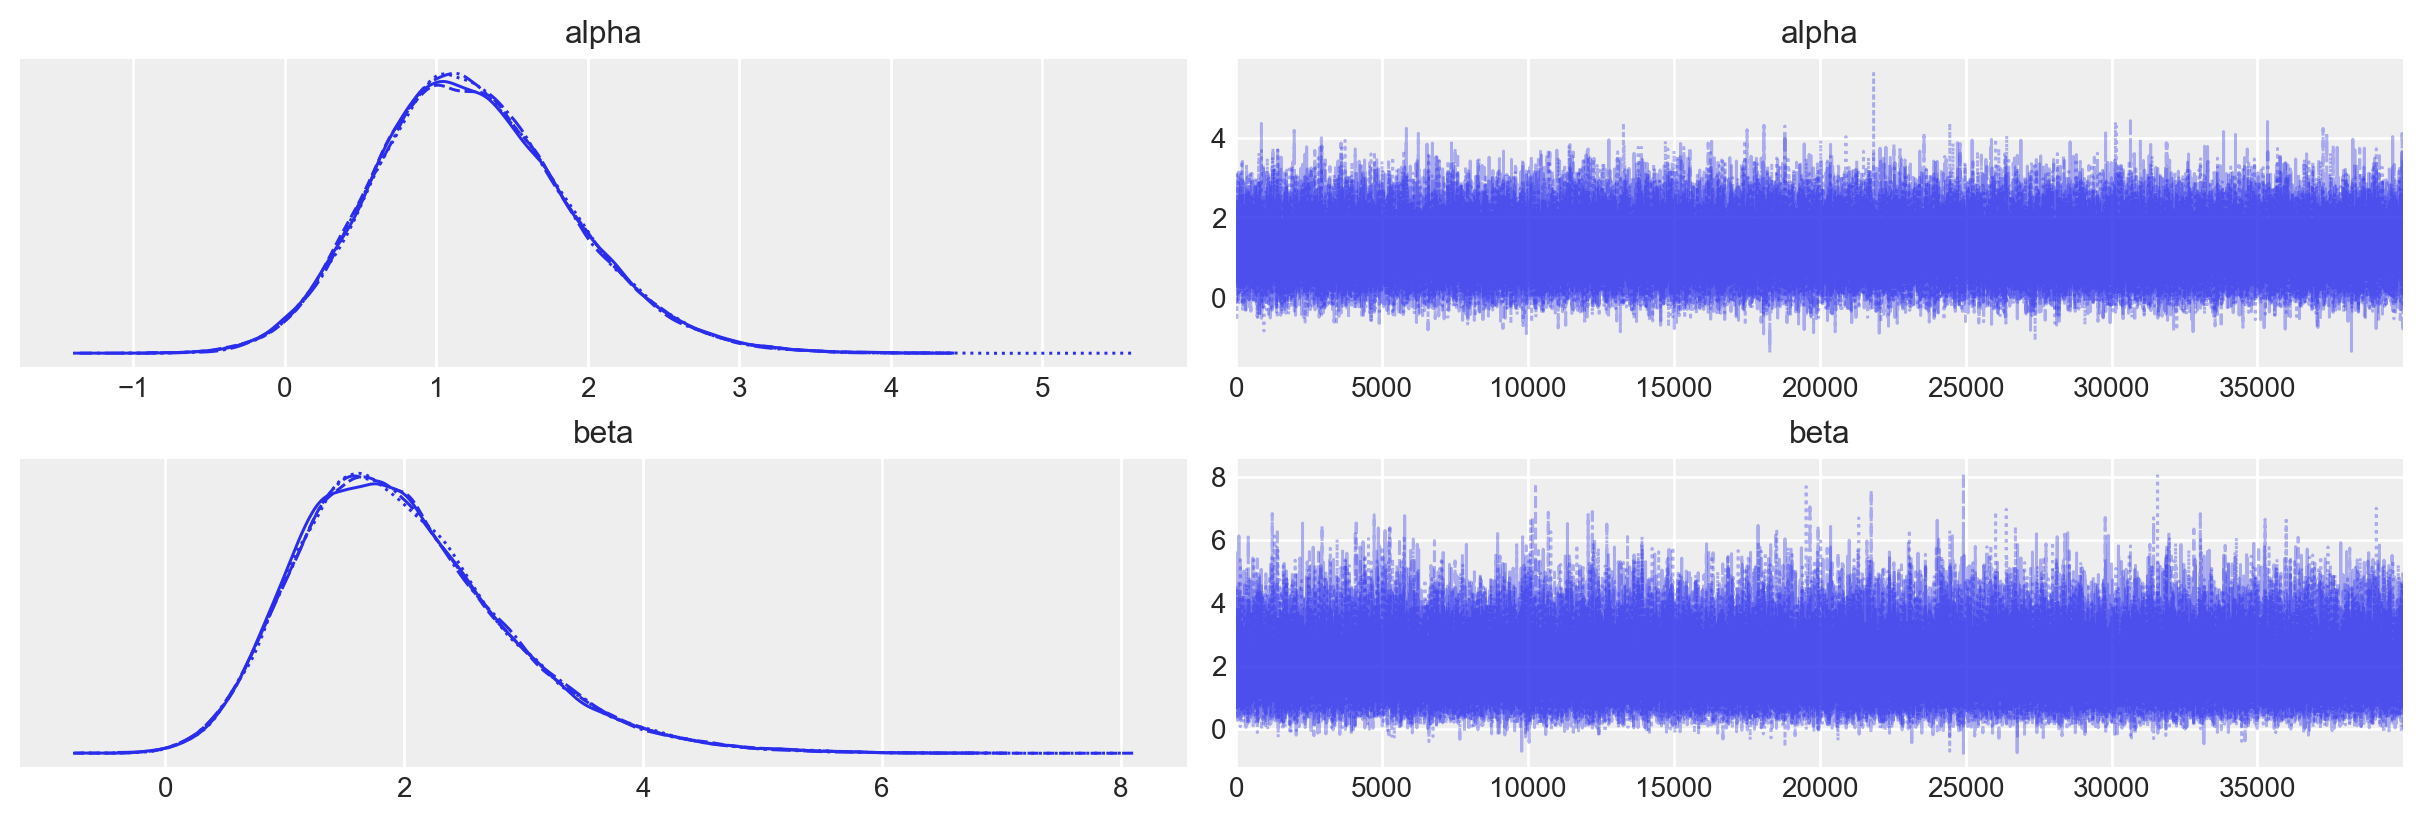

In [24]:
var_names=['alpha', 'beta']
pm.traceplot(trace, var_names=var_names);

Got error No model on context stack. trying to find log_likelihood in translation.


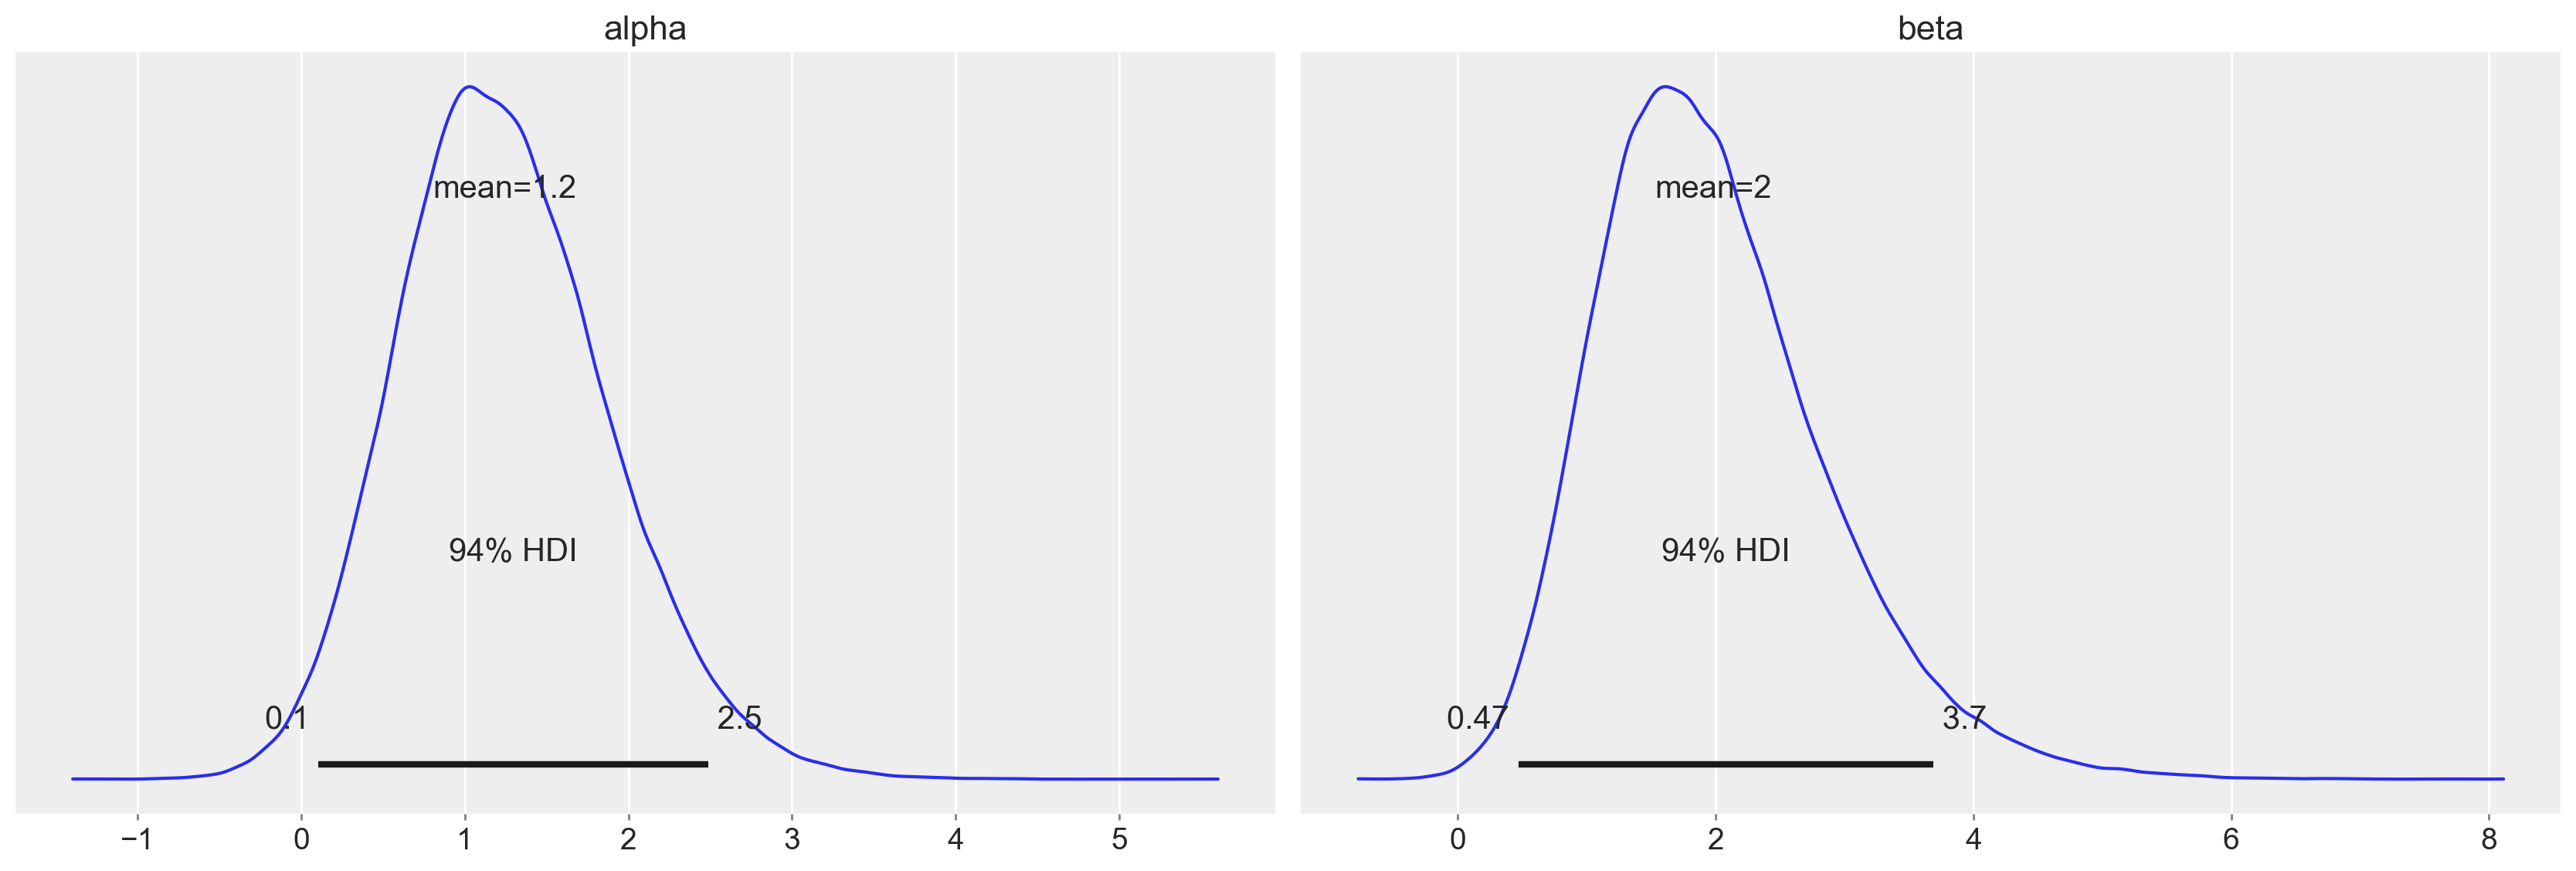

In [25]:
_=pm.plot_posterior(trace, var_names=var_names)

Got error No model on context stack. trying to find log_likelihood in translation.


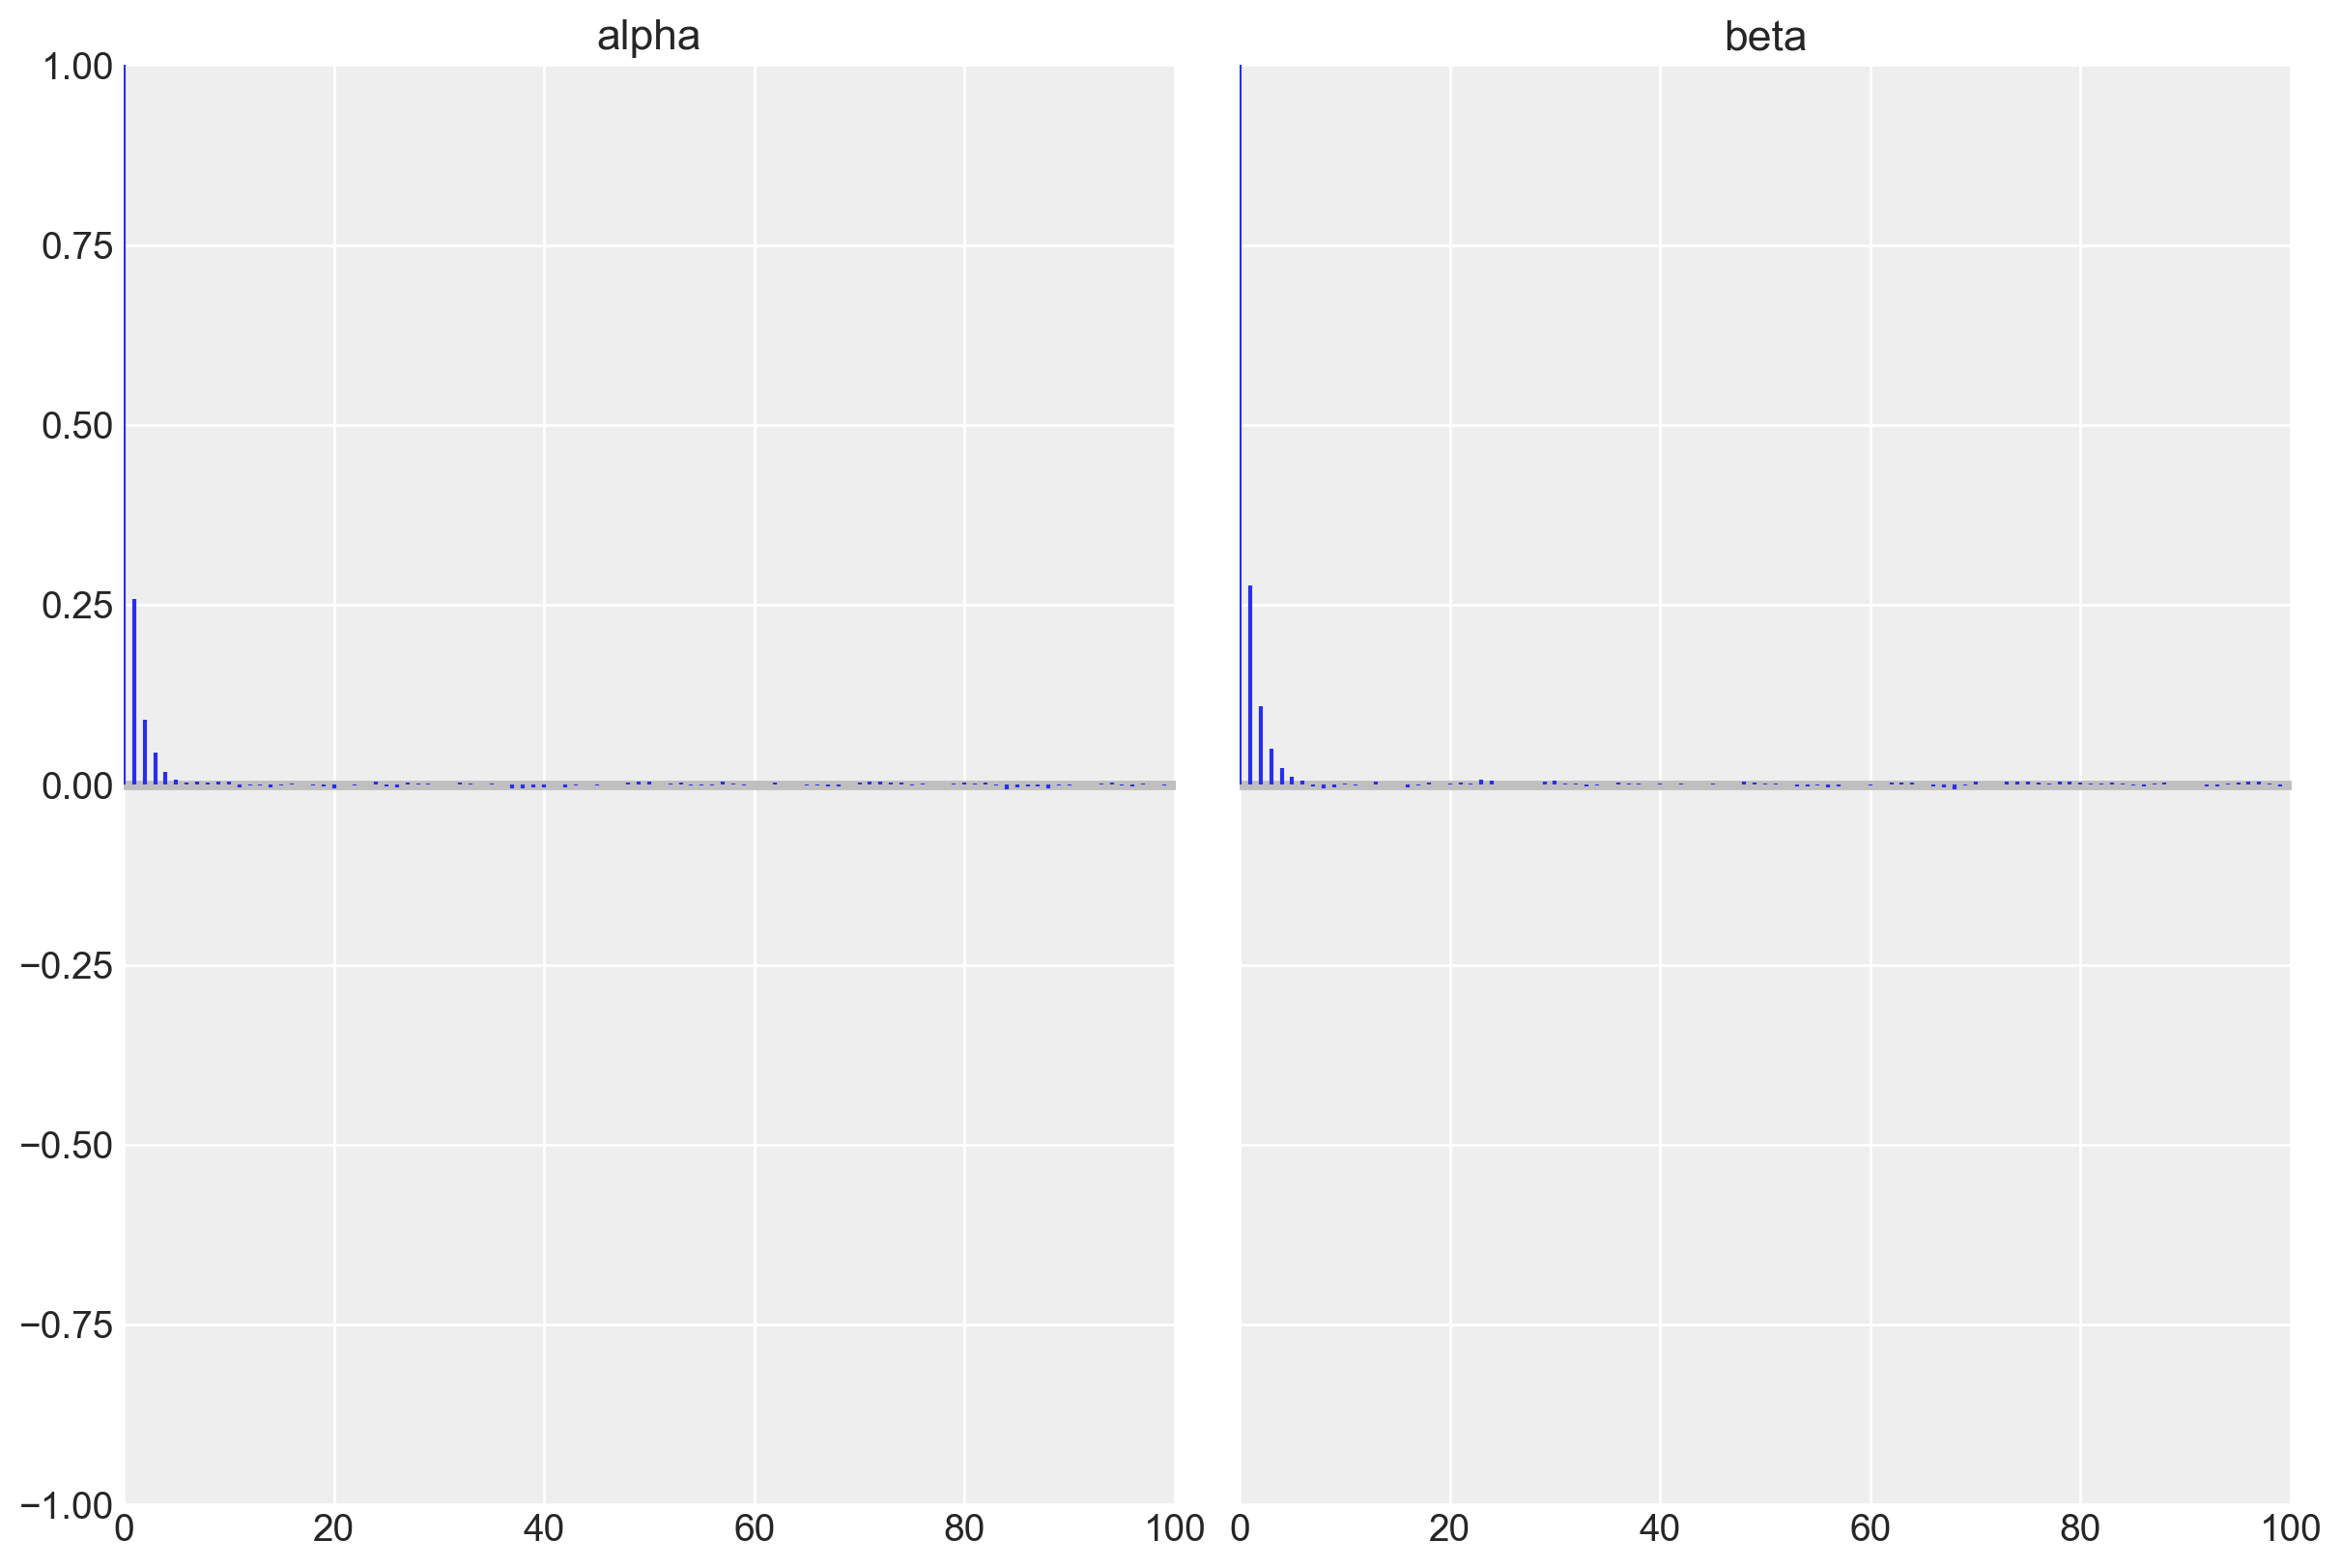

In [26]:
_=pm.plot_autocorr(trace, var_names=var_names, figsize=(12, 8), combined=True)

/var/folders/5y/28n32xmx0551k29hd21qs87c0000gp/T/ipykernel_43649/2563560967.py:2: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  _=pm.autocorrplot(thinned_trace, var_names=var_names, figsize=(12, 8), combined=True)
Got error No model on context stack. trying to find log_likelihood in translation.


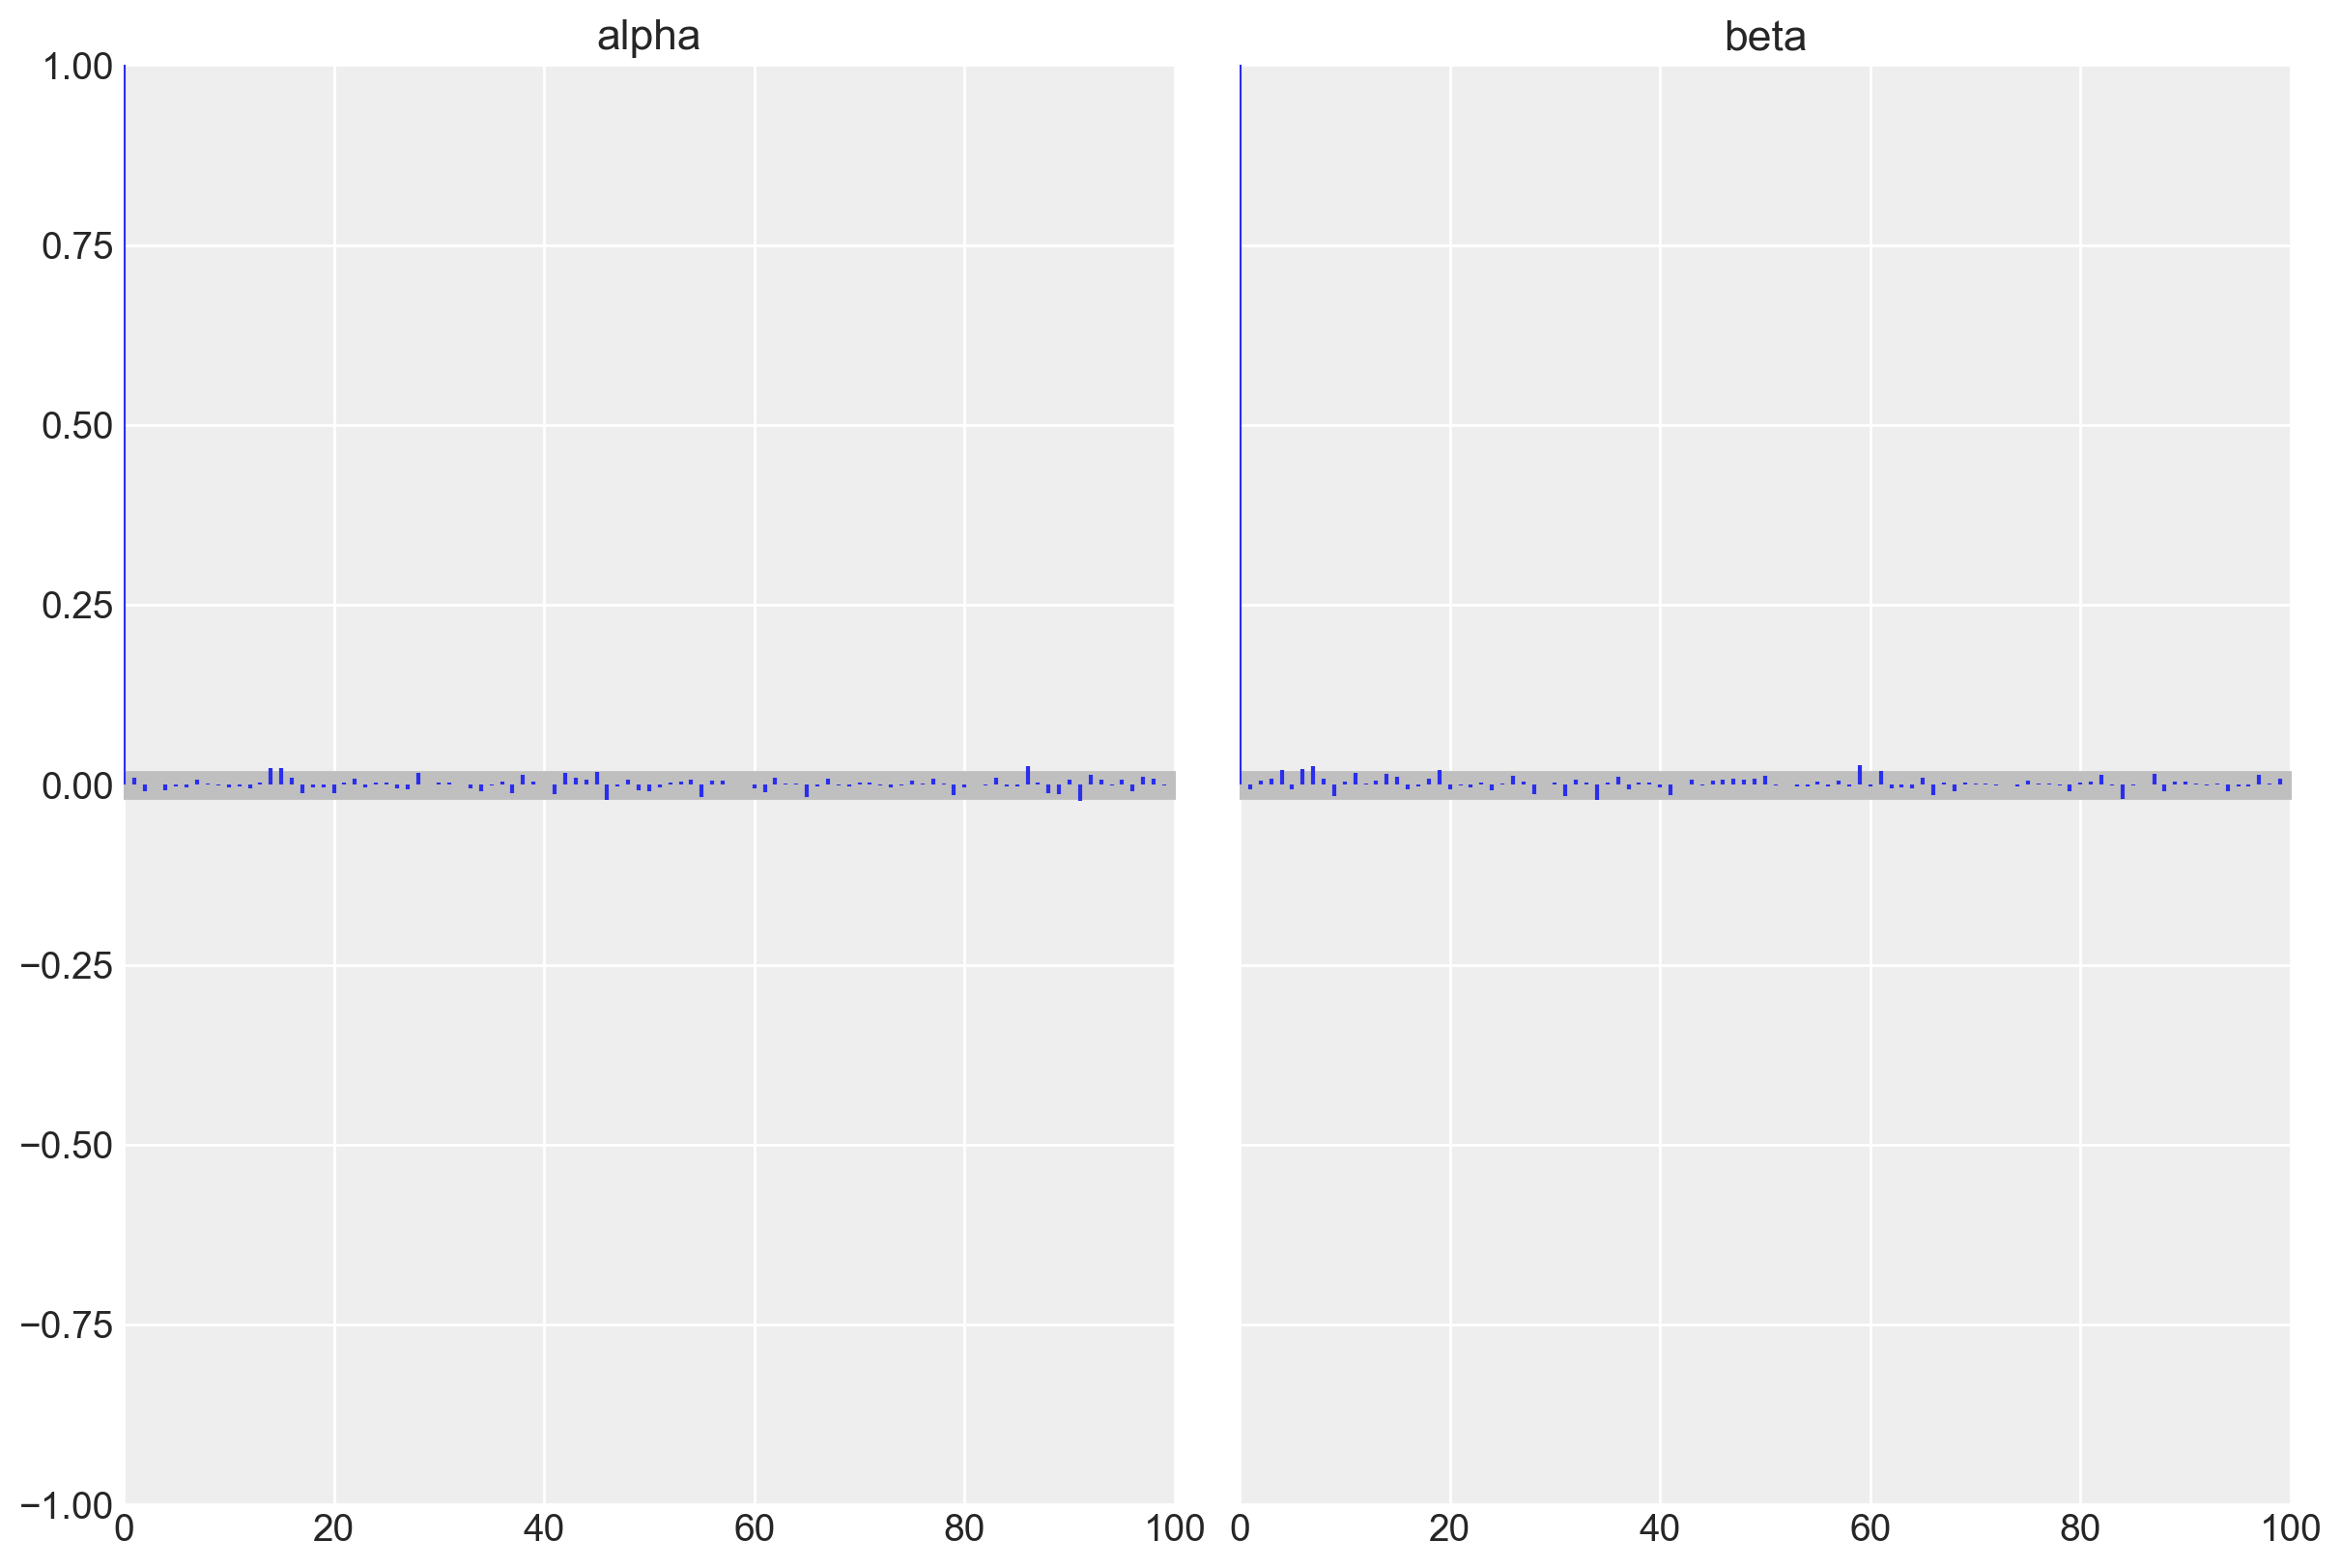

In [27]:
thinned_trace = trace[10000::10]
_=pm.autocorrplot(thinned_trace, var_names=var_names, figsize=(12, 8), combined=True)

### Posterior predictive distribution

We can use the samples of posterior generated from MCMC to get a predictive over the probability of failure at any given temperature. 

In [28]:
with challenger_model:
    ppsamples = pm.sample_posterior_predictive(trace=thinned_trace, 
                                               samples=2000,
                                               var_names=['p'])['p']

/opt/homebrew/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [29]:
# get posterior predictive mean and 95% interval
ppmean = ppsamples.mean(axis=0)
pp_lower, pp_upper = np.percentile(ppsamples, axis=0, q=[2.5, 97.5])

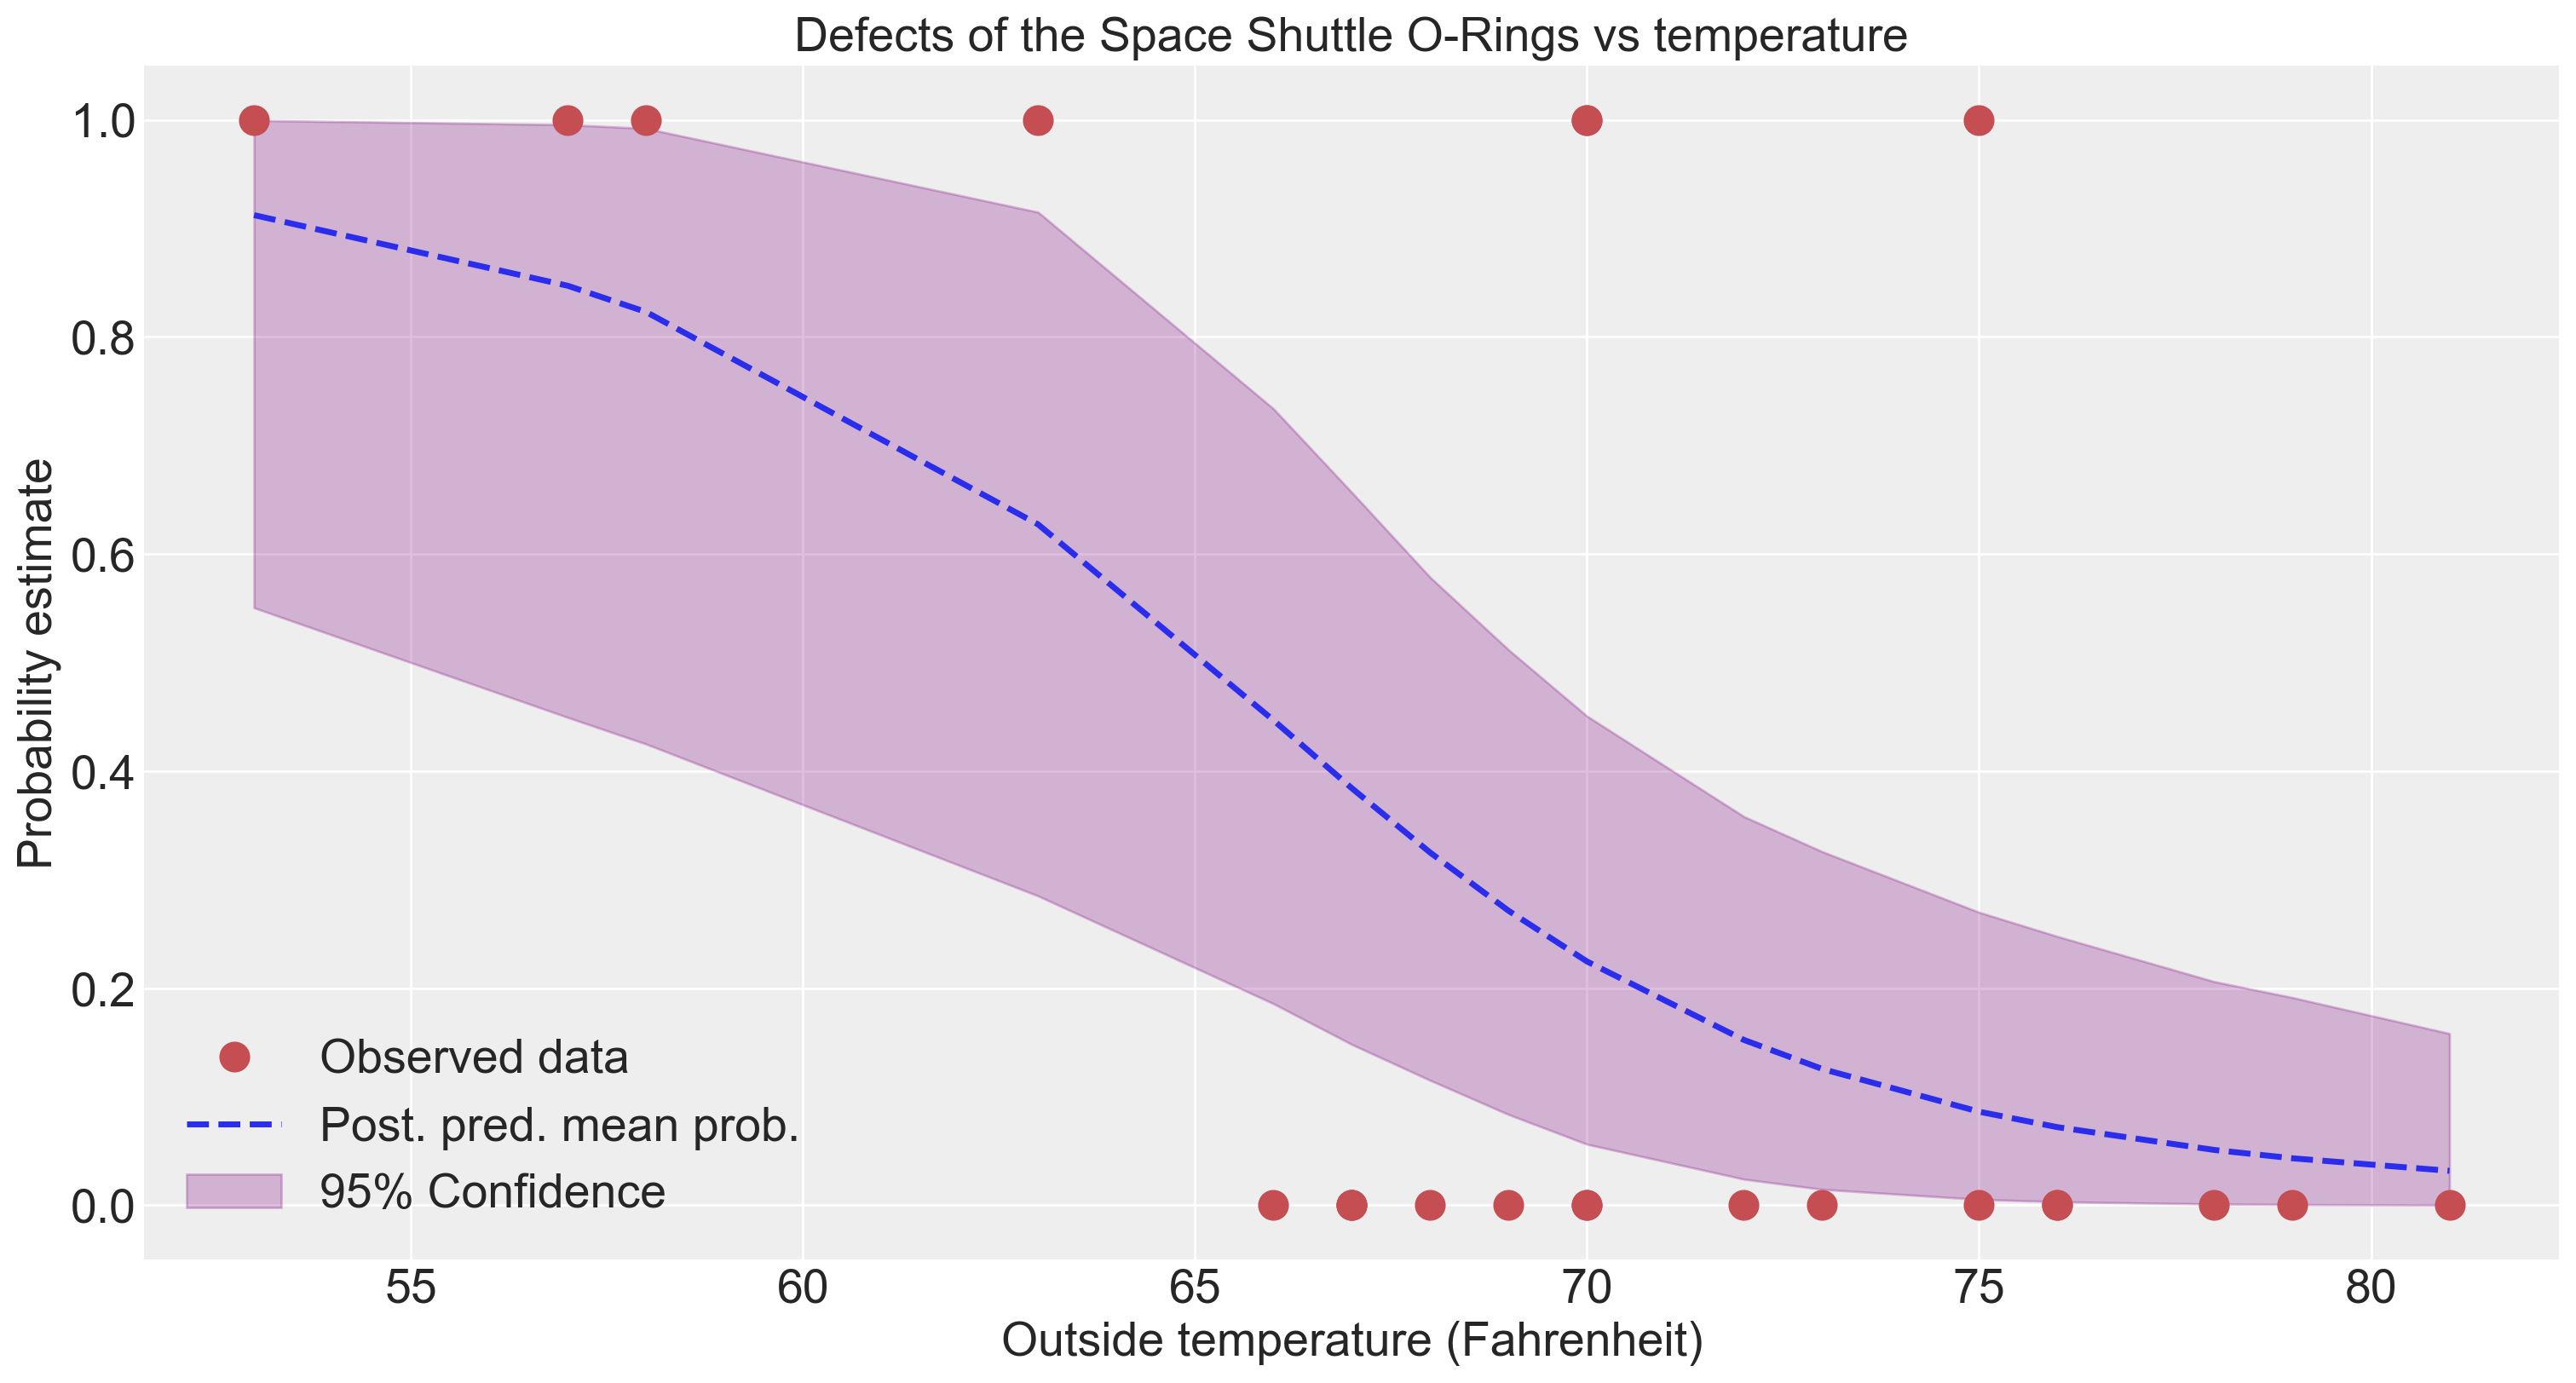

In [30]:
plt.figure(figsize=(15, 8))
plt.plot(temp, data, 'ro', markersize=12, label='Observed data')
idx=np.argsort(temp)
plt.plot(temp[idx], ppmean[idx], linestyle='--', linewidth=2.5, 
         label='Post. pred. mean prob.')
plt.fill_between(temp[idx], pp_lower[idx], pp_upper[idx], 
                color='purple', alpha=0.25, label='95% Confidence')
plt.ylabel("Probability estimate",fontsize=20)
plt.xlabel("Outside temperature (Fahrenheit)",fontsize=20)
plt.title("Defects of the Space Shuttle O-Rings vs temperature",
          fontsize=20)
plt.yticks(np.arange(0., 1.01, 0.2), fontsize=20)
plt.xticks(fontsize=20)
plt.legend(loc='best', fontsize=20);

The *95% credible interval*, or 95% CI, painted in purple, represents the interval, for each temperature, that contains 95% of the distribution. For example, at 65 degrees, we can be 95% sure that the probability of defect lies between 0.25 and 0.75.

More generally, we can see that as the temperature nears 60 degrees, the CI's spread out quickly. As we pass 70 degrees, the CI's tighten again. This can give us insight about how to proceed next: we should probably test more O-rings around 60-65 temperature to get a better estimate of probabilities in that range. Similarly, when reporting to scientists your estimates, you should be very cautious about simply telling them the expected probability, as we can see this does not reflect how *wide* the posterior distribution is.

### Question

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distribution of a defect occurring,  given this temperature? The distribution is plotted below. It looks almost guaranteed that the Challenger was going to be subject to defective O-rings.